Model 1:
The analysis in this notebook only focuses on default and fully paid applications, ignoring current applications. Creates credit scoring model using SVM and random forest classification considering rejected applications and class imbalancing methods into picture. 

The results will be  compared with the model with current records and analysed further.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
from matplotlib import pyplot as plt
from IPython.display import display
from dateutil import parser
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import roc_auc_score

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

<h3>Loading the dataset </h3>

In [ ]:
# Import the dataset
#loan_df = pd.read_csv('../Research topic and datasets/Datasets/LendingClub/LC-2007-18-kaggle/LC_dataset_accepted_2016_18.csv')
path='/content/drive/My Drive/Colab Notebooks/LJMU Thesis/LC_dataset_accepted_2016_17.csv'
loan_df = pd.read_csv(path)

In [ ]:
# making a copy to avoid re - reading the whole data set.
df = loan_df.copy(deep=True)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,83972820,NaN,10000.0,10000.0,10000.0,60 months,13.49,230.05,C,C2,Customer Service,3 years,RENT,32000.0,Not Verified,Jun-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,447xx,OH,13.05,0.0,Apr-1999,750.0,754.0,1.0,NaN,NaN,5.0,0.0,16525.0,47.3,10.0,w,0.00,0.00,10356.270252,10356.27,10000.00,356.27,0.0,0.0,0.0,Oct-2017,454.31,NaN,Oct-2017,769.0,765.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,112399.0,0.0,0.0,0.0,0.0,67.0,0.0,NaN,0.0,0.0,9296.0,47.0,34900.0,1.0,0.0,1.0,0.0,22480.0,18375.0,47.3,0.0,0.0,94.0,206.0,84.0,67.0,1.0,84.0,NaN,6.0,NaN,0.0,2.0,2.0,4.0,7.0,2.0,4.0,7.0,2.0,5.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,141464.0,16525.0,34900.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,84333484,NaN,12000.0,12000.0,12000.0,36 months,15.59,419.46,C,C5,Executive Assistant,7 years,MORTGAGE,70000.0,Verified,Jun-2016,Late (31-120 days),n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,774xx,TX,22.86,0.0,Aug-2000,695.0,699.0,1.0,NaN,NaN,18.0,0.0,20075.0,56.7,45.0,f,2406.15,2406.15,12479.870000,12479.87,9593.85,2886.02,0.0,0.0,0.0,Dec-2018,419.46,Apr-2019,Mar-2019,619.0,615.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,156605.0,2.0,3.0,1.0,1.0,4.0,31445.0,74.0,1.0,5.0,6031.0,66.0,35400.0,0.0,2.0,3.0,6.0,9212.0,140.0,99.1,0.0,0.0,120.0,190.0,2.0,2.0,1.0,13.0,NaN,2.0,NaN,0.0,5.0,8.0,5.0,13.0,12.0,14.0,32.0,8.0,18.0,0.0,0.0,0.0,2.0,100.0,100.0,0.0,0.0,191070.0,5

<h3>Understanding the dataset</h3>

In [ ]:
df.shape

(870840, 151)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870840 entries, 0 to 870839
Columns: 151 entries, id to settlement_term
dtypes: float64(113), int64(1), object(37)
memory usage: 1003.2+ MB


<h3> Check Missing Values </h3>

In [ ]:
# Checking for missing values
total_miss_data= df.isnull().sum().sort_values(ascending=False)
percent_miss_data= (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)*100
missing_data= pd.concat([total_miss_data, percent_miss_data],axis=1, keys=["Total", "Percent"])
missing_data

,Total,Percent
member_id,870840,100.000000
desc,870817,99.997359
orig_projected_additional_accrued_interest,865112,99.342244
hardship_dpd,863499,99.157021
hardship_start_date,863499,99.157021
hardship_type,863499,99.157021
hardship_reason,863499,99.157021
hardship_status,863499,99.157021
deferral_term,863499,99.157021
hardship_last_payment_amount,863499,99.157021


About 99% percent of data for the following columns are missing. Cleaning the missing data
1. member_id - A unique LC assigned Id for the borrower member.
2. desc - Loan description provided by the borrower
3. orig_projected_additional_accrued_interest - 
4. hardship_dpd
5. hardship_start_date
6. hardship_type
7. hardship_reason
8. hardship_status
9. deferral_term
10. hardship_last_payment_amount
11. hardship_payoff_balance_amount
12. hardship_loan_status
13. hardship_amount
14. hardship_length
15. payment_plan_start_date
16. hardship_end_date
17. settlement_term
18. settlement_percentage
19. debt_settlement_flag_date
20. settlement_status
21. settlement_date
22. settlement_amount
23. sec_app_mths_since_last_major_derog


In [ ]:
# Remove missing value columns for hardship plan introduced in March 2017 for a selective borrowers. About 99.99% data is missing. Removing the columns

df.drop(["member_id", "desc", "orig_projected_additional_accrued_interest","hardship_end_date","deferral_term","payment_plan_start_date"], axis=1, inplace=True)
df.drop(["hardship_length", "hardship_dpd", "hardship_loan_status","hardship_last_payment_amount","hardship_payoff_balance_amount","hardship_amount"], axis=1, inplace=True)
df.drop(["hardship_status", "hardship_reason", "hardship_type","hardship_start_date"], axis=1, inplace=True)

# Removing settlement related attributes that were introduced in Sep 2017 as part of settlement - More than 99% data is missing, removing them

df.drop(["settlement_term", "settlement_percentage", "debt_settlement_flag_date","settlement_status","settlement_date","settlement_amount","sec_app_mths_since_last_major_derog"], axis=1, inplace=True)
df.drop(["sec_app_revol_util", "verification_status_joint", "revol_bal_joint","sec_app_inq_last_6mths","sec_app_fico_range_low","sec_app_fico_range_high","sec_app_earliest_cr_line","sec_app_mort_acc","sec_app_open_acc","sec_app_open_act_il"], axis=1, inplace=True)
df.drop(["sec_app_num_rev_accts", "sec_app_chargeoff_within_12_mths", "sec_app_collections_12_mths_ex_med","annual_inc_joint","dti_joint"], axis=1, inplace=True)


In [ ]:
#Checking for missing data post 1st level of cleanup

total_miss_data= df.isnull().sum().sort_values(ascending=False)
percent_miss_data= (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)*100
missing_data= pd.concat([total_miss_data, percent_miss_data],axis=1, keys=["Total", "Percent"])
missing_data

,Total,Percent
mths_since_last_record,712698,81.840292
mths_since_recent_bc_dlq,658756,75.646043
mths_since_last_major_derog,628531,72.175256
mths_since_recent_revol_delinq,566759,65.081875
next_pymnt_d,458737,52.677530
mths_since_last_delinq,424125,48.702976
il_util,118424,13.598824
mths_since_recent_inq,96529,11.084585
emp_title,60837,6.986014
emp_length,60083,6.899430


In [ ]:
# Handling missing values and imputing them with median wherever necessary
# 1. inq_last_6mths - The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
df['inq_last_6mths'].median()
df['inq_last_6mths'].value_counts(dropna=False)

# Impute the missing value NaN with median
df['inq_last_6mths'] =df['inq_last_6mths'].fillna(df['inq_last_6mths'].median())
# Verify the NaN values 
df['inq_last_6mths'].value_counts(dropna=False)

0.0    546411
1.0    223586
2.0     70998
3.0     21818
4.0      5989
5.0      2038
Name: inq_last_6mths, dtype: int64

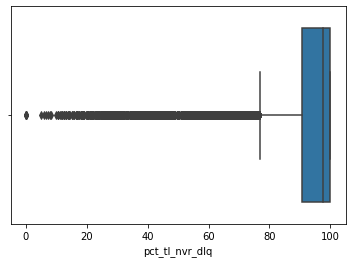

In [ ]:
# 2. pct_tl_nvr_dlq - Percent of trades never delinquent
df['pct_tl_nvr_dlq'].value_counts(dropna=False)
sns.boxplot(df['pct_tl_nvr_dlq'])

df['pct_tl_nvr_dlq'].median()
df['pct_tl_nvr_dlq'].mean()
df['pct_tl_nvr_dlq'].mode()

df['pct_tl_nvr_dlq'] =df['pct_tl_nvr_dlq'].fillna(df['pct_tl_nvr_dlq'].median())

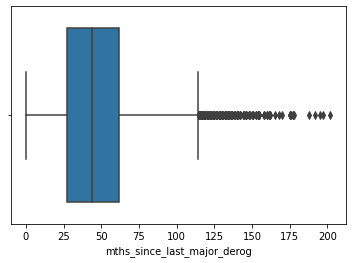

In [ ]:
# 3. mths_since_last_major_derog - Months since most recent 90-day or worse rating
df['mths_since_last_major_derog'].value_counts(dropna=False)

#removing the column where more than 70% data is missing
sns.boxplot(df['mths_since_last_major_derog'])

df['mths_since_last_major_derog'].median()
df['mths_since_last_major_derog'].mode()
df['mths_since_last_major_derog'].mean()

df.drop(["mths_since_last_major_derog"], axis=1, inplace=True)

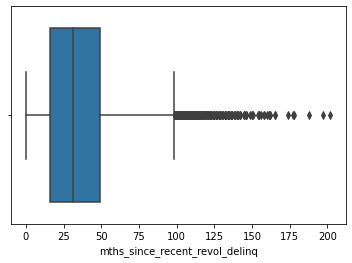

In [ ]:
# mths_since_recent_revol_delinq - Months since most recent revolving delinquency.
sns.boxplot(df['mths_since_recent_revol_delinq'])
df['mths_since_recent_revol_delinq'].mean()
df['mths_since_recent_revol_delinq'].median()
df['mths_since_recent_revol_delinq'].mode()

# Imputing the value with 0. Because not all borrowers may not deliquent
df['mths_since_recent_revol_delinq'].fillna(0,inplace=True)

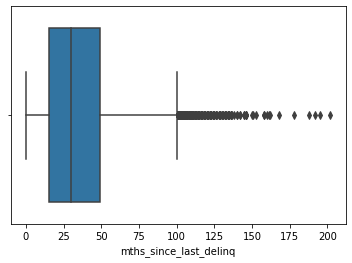

In [ ]:
# mths_since_last_delinq - The number of months since the borrower's last delinquency.
df['mths_since_last_delinq'].value_counts(dropna=False)
sns.boxplot(df['mths_since_last_delinq'])
df['mths_since_last_delinq'].median()
df['mths_since_last_delinq'].mode()
df['mths_since_last_delinq'].mean()

# Imputing the value with median 
df['mths_since_last_delinq'] =df['mths_since_last_delinq'].fillna(df['mths_since_last_delinq'].median())

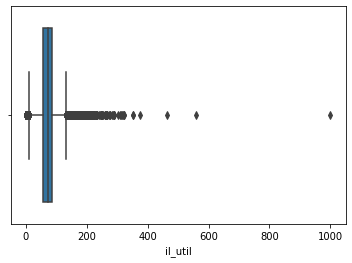

In [ ]:
# il_util - Ratio of total current balance to high credit/credit limit on all install acct
df['il_util'].value_counts(dropna=False)
sns.boxplot(df['il_util'])

df['il_util'].mode()
df['il_util'].median()
df['il_util'].mean()

df['il_util'] =df['il_util'].fillna(df['il_util'].median())

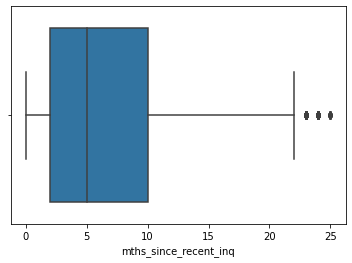

In [ ]:
# mths_since_recent_inq - Months since most recent inquiry.
sns.boxplot(df['mths_since_recent_inq'])
df['mths_since_recent_inq'].value_counts(dropna=False)
df['mths_since_recent_inq'].median()

# Imputing the value with median
df['mths_since_recent_inq'] =df['mths_since_recent_inq'].fillna(df['mths_since_recent_inq'].median())

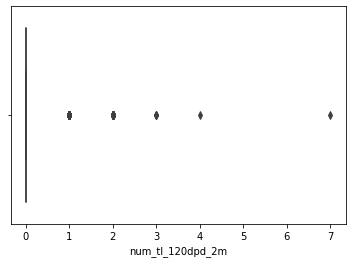

In [ ]:
# num_tl_120dpd_2m - Number of accounts currently 120 days past due (updated in past 2 months)
sns.boxplot(df['num_tl_120dpd_2m'])
df['num_tl_120dpd_2m'].value_counts(dropna=False)
df['num_tl_120dpd_2m'] =df['num_tl_120dpd_2m'].fillna(df['num_tl_120dpd_2m'].median())

In [ ]:
# Impute values with median - removed 'num_mths_for_next_pymnt'
col=['mths_since_rcnt_il','mo_sin_old_il_acct','bc_util','percent_bc_gt_75','bc_open_to_buy','mths_since_recent_bc','revol_util','all_util','open_acc_6m','total_cu_tl','inq_last_12m','max_bal_bc','open_rv_24m','open_il_12m','open_il_24m','inq_fi','total_bal_il','open_act_il','open_rv_12m','avg_cur_bal']
df[col]=df[col].fillna(df[col].median())
df.isnull().sum()

id                                     0
loan_amnt                              0
funded_amnt                            0
funded_amnt_inv                        0
term                                   0
int_rate                               0
installment                            0
grade                                  0
sub_grade                              0
emp_title                          60837
emp_length                         60083
home_ownership                         0
annual_inc                             0
verification_status                    0
issue_d                                0
loan_status                            0
pymnt_plan                             0
url                                    0
purpose                                0
title                              23088
zip_code                               1
addr_state                             0
dti                                  577
delinq_2yrs                            0
earliest_cr_line

In [ ]:
df.dtypes.value_counts().sort_values()

int64       1
object     24
float64    87
dtype: int64

In [ ]:
# Gives number of unique values for each category
df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

term                         2
grade                        7
sub_grade                   35
emp_title               199645
emp_length                  11
home_ownership               5
verification_status          3
issue_d                     24
loan_status                  7
pymnt_plan                   2
url                     870840
purpose                     14
title                       14
zip_code                   923
addr_state                  50
earliest_cr_line           707
initial_list_status          2
last_pymnt_d                39
next_pymnt_d                 4
last_credit_pull_d          41
application_type             2
hardship_flag                2
disbursement_method          2
debt_settlement_flag         2
dtype: int64

<h3> Data cleaning </h3>

In [ ]:
# Dropping unwanted columns like id, url etc., that doesn't help in the analysis
df.drop(["id","url","zip_code","addr_state"], axis=1, inplace=True)

In [ ]:
df.info(max_cols=110)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870840 entries, 0 to 870839
Data columns (total 108 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   loan_amnt                       870840 non-null  float64
 1   funded_amnt                     870840 non-null  float64
 2   funded_amnt_inv                 870840 non-null  float64
 3   term                            870840 non-null  object 
 4   int_rate                        870840 non-null  float64
 5   installment                     870840 non-null  float64
 6   grade                           870840 non-null  object 
 7   sub_grade                       870840 non-null  object 
 8   emp_title                       810003 non-null  object 
 9   emp_length                      810757 non-null  object 
 10  home_ownership                  870840 non-null  object 
 11  annual_inc                      870840 non-null  float64
 12  verification_st

In [ ]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,10000.0,10000.0,10000.0,60 months,13.49,230.05,C,C2,Customer Service,3 years,RENT,32000.0,Not Verified,Jun-2016,Fully Paid,n,debt_consolidation,Debt consolidation,13.05,0.0,Apr-1999,750.0,754.0,1.0,30.0,NaN,5.0,0.0,16525.0,47.3,10.0,w,0.00,0.00,10356.270252,10356.27,10000.00,356.27,0.0,0.0,0.0,Oct-2017,454.31,NaN,Oct-2017,769.0,765.0,0.0,1.0,Individual,0.0,0.0,112399.0,0.0,0.0,0.0,0.0,67.0,0.0,73.0,0.0,0.0,9296.0,47.0,34900.0,1.0,0.0,1.0,0.0,22480.0,18375.0,47.3,0.0,0.0,94.0,206.0,84.0,67.0,1.0,84.0,NaN,6.0,0.0,0.0,2.0,2.0,4.0,7.0,2.0,4.0,7.0,2.0,5.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,141464.0,16525.0,34900.0,0.0,N,Cash,N
1,12000.0,12000.0,12000.0,36 months,15.59,419.46,C,C5,Executive Assistant,7 years,MORTGAGE,70000.0,Verified,Jun-2016,Late (31-120 days),n,debt_consolidation,Debt consolidation,22.86,0.0,Aug-2000,695.0,699.0,1.0,30.0,NaN,18.0,0.0,20075.0,56.7,45.0,f,2406.15,2406.15,12479.870000,12479.87,9593.85,2886.02,0.0,0.0,0.0,Dec-2018,419.46,Apr-2019,Mar-2019,619.0,615.0,0.0,1.0,Individual,0.0,0.0,156605.0,2.0,3.0,1.0,1.0,4.0,31445.0,74.0,1.0,5.0,6031.0,66.0,35400.0,0.0,2.0,3.0,6.0,9212.0,140.0,99.1,0.0,0.0,120.0,190.0,2.0,2.0,1.0,13.0,NaN,2.0,0.0,0.0,5.0,8.0,5.0,13.0,12.0,14.0,32.0,8.0,18.0,0.0,0.0,0.0,2.0,100.0,100.0,0.0,0.0,191070.0,51520.0,15200.0,42753.0,N,Cash,N
2,4900.0,4900.0,4900.0,36 months,10.99,160.40,B,B4,Campaign Manager,< 1 year,MORTGAGE,120000.0,Verified,Jun-2016,Current,n,home_improvement,Home improvement,6.07,0.0,Mar-2003,680.0,684.0,0.0,49.0,NaN,5.0,0.0,7244.0,80.5,8.0,f,627.03,627.03,5125.320000,5125.32,4272.97,852.35,0.0,0.0,0.0,Feb-2019,160.40,Apr-2019,Mar-2019,739.0,735.0,0.0,1.0,Individual,0.0,65.0,151803.0,1.0,2.0,0.0,0.0,39.0,20640.0,66.0,1.0,1.0,3689.0,69.0,9000.0,0.0,0.0,0.0,1.0,30361.0,1756.0,80.5,0.0,0.0,159.0,34.0,5.0,5.0,1.0,5.0,NaN,5.0,0.0,1.0,2.0,2.0,2.0,2.0,5.0,2.0,2.0,2.0,5.0,0.0,0.0,0.0,1.0,62.5,50.0,0.0,0.0,183092.0,27884.0,9000.0,31515.0,N,Cash,N
3,21000.0,21000.0,21000.0,60 months,14.49,493.99,C,C4,Administrative Assistant,< 1 year,MORTGAGE,80000.0,Source Verified,Jun-2016,Fully Paid,n,debt_consolidation,Debt consolidation,9.87,0.0,May-1994,735.0,739.0,0.0,30.0,NaN,9.0,0.0,25137.0,79.3,12.0,w,0.00,0.00,23801.115790,23801.12,21000.00,2801.12,0.0,0.0,0.0,Jun-2017,18903.48,NaN,Nov-2017,794.0,790.0,0.0,1.0,Individual,0.0,0.0,475196.0,0.0,0.0,0.0,0.0,13.0,0.0,73.0,0.0,1.0,10081.0,79.0,31700.0,1.0,0.0,0.0,1.0,59400.0,3685.0,86.3,0.0,0

In [ ]:
#compare if loan_amnt, funded_amt, funded_amt_inv same or not?
df['loan_funded_match'] = np.where(df['loan_amnt'] == df['funded_amnt'], True, False)

In [ ]:
df['loan_funded_match'].value_counts()

True     870837
False         3
Name: loan_funded_match, dtype: int64

In [ ]:
df[df.loan_funded_match == False]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,loan_funded_match
32103,18000.0,10000.0,10000.0,36 months,12.99,336.90,C,C2,Manager,6 years,RENT,60000.0,Source Verified,Jun-2016,Current,n,small_business,Business,20.45,0.0,Nov-2008,685.0,689.0,1.0,30.0,NaN,9.0,0.0,15537.0,43.4,12.0,w,273.39,273.39,11660.48,11660.48,9726.61,1933.87,0.0,0.0,0.0,Mar-2019,336.90,Apr-2019,Mar-2019,694.0,690.0,0.0,1.0,Individual,0.0,155.0,28657.0,1.0,1.0,0.0,0.0,28.0,12376.0,62.0,1.0,1.0,4705.0,51.0,35800.0,0.0,1.0,2.0,1.0,3184.0,19046.0,39.7,0.0,0.0,74.0,90.0,4.0,4.0,0.0,43.0,NaN,4.0,0.0,0.0,4.0,5.0,5.0,6.0,2.0,7.0,9.0,5.0,9.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,56761.0,28657.0,31600.0,20045.0,N,Cash,N,False
32181,20000.0,10000.0,10000.0,36 months,7.39,310.56,A,A4,manager,10+ years,MORTGAGE,55000.0,Verified,Jun-2016,Current,n,debt_consolidation,Debt consolidation,20.77,0.0,Jul-1996,705.0,709.0,0.0,58.0,NaN,10.0,0.0,16751.0,61.4,37.0,w,920.52,920.52,10244.37,10244.37,9079.48,1164.89,0.0,0.0,0.0,Mar-2019,310.56,Apr-2019,Mar-2019,744.0,740.0,0.0,1.0,Joint App,0.0,0.0,53218.0,0.0,1.0,1.0,1.0,12.0,1699.0,52.0,1.0,2.0,7589.0,60.0,27300.0,0.0,1.0,1.0,3.0,6652.0,4263.0,69.5,0.0,0.0,112.0,237.0,10.0,10.0,6.0,10.0,NaN,12.0,0.0,1.0,2.0,3.0,5.0,18.0,2.0,8.0,28.0,3.0,10.0,0.0,0.0,0.0,2.0,97.3,66.7,0.0,0.0,190551.0,18450.0,14000.0,3251.0,N,Cash,N,False
32428,20000.0,10000.0,10000.0,60 months,11.47,219.78,B,B5,Fuel Manager,10+ years,MORTGAGE,50000.0,Verified,Jun-2016,Current,n,debt_consolidation,Debt consolidation,28.13,0.0,Aug-2000,680.0,684.0,0.0,30.0,NaN,6.0,0.0,15590.0,95.0,15.0,w,5208.11,5208.11,7246.37,7246.37,4791.89,2454.48,0.0,0.0,0.0,Mar-2019,219.78,Apr-2019,Mar-2019,684.0,680.0,0.0,1.0,Individual,0.0,0.0,54279.0,0.0,2.0,0.0,1.0,14.0,38689.0,83.0,1.0,1.0,3726.0,95.0,16350.0,0.0,0.0,0.0,2.0,9046.0,3217.0,94.0,0.0,0.0,188.0,127.0,11.0,11.0,0.0,11.0,NaN,14.0,0.0,0.0,3.0,4.0,3.0,3.0,8.0,4.0,7.0,4.0,6.0,0.0,0.0,0.0,1.0,100.0,100.0,0.0,0.0,62990.0,54279.0,9650.0,46640.0,N,Cash,N,False


In [ ]:
df['funded_funded_inv_match'] = np.where(df['funded_amnt'] == df['funded_amnt_inv'], True, False)

df[df.funded_funded_inv_match == False]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,loan_funded_match,funded_funded_inv_match
17,22000.0,22000.0,21975.0,36 months,6.99,679.20,A,A2,Teacher,10+ years,RENT,73000.0,Source Verified,Jun-2016,Current,n,credit_card,Credit card refinancing,21.24,2.0,Sep-2000,690.0,694.0,0.0,16.0,NaN,24.0,0.0,22101.0,40.9,45.0,f,2013.93,2011.64,22338.090000,22312.71,19986.07,2352.02,0.00,0.0,0.0,Mar-2019,679.20,Apr-2019,Mar-2019,704.0,700.0,0.0,1.0,Individual,0.0,0.0,59073.0,1.0,6.0,0.0,1.0,15.0,36972.0,93.0,2.0,3.0,5884.0,63.0,54000.0,0.0,0.0,1.0,4.0,2461.0,26130.0,45.3,0.0,0.0,164.0,189.0,4.0,4.0,0.0,4.0,47.0,11.0,16.0,0.0,11.0,14.0,12.0,22.0,14.0,18.0,31.0,15.0,24.0,0.0,0.0,0.0,2.0,91.1,33.3,0.0,0.0,93893.0,59073.0,47800.0,39893.0,N,Cash,N,True,False
65,24000.0,24000.0,23950.0,36 months,10.49,779.95,B,B3,ACCOUNTING MANAGER,1 year,MORTGAGE,120000.0,Source Verified,Jun-2016,Current,n,credit_card,Credit card refinancing,9.39,0.0,Aug-1993,690.0,694.0,1.0,30.0,NaN,19.0,0.0,57133.0,56.3,61.0,f,3052.61,3046.25,24923.430000,24871.51,20947.39,3976.04,0.00,0.0,0.0,Feb-2019,779.95,Apr-2019,Mar-2019,699.0,695.0,0.0,1.0,Individual,0.0,0.0,333131.0,2.0,1.0,2.0,3.0,4.0,16408.0,97.0,2.0,6.0,20788.0,62.0,101500.0,8.0,1.0,13.0,10.0,18507.0,41867.0,57.7,0.0,0.0,52.0,274.0,4.0,4.0,1.0,4.0,NaN,4.0,0.0,0.0,8.0,8.0,14.0,47.0,5.0,17.0,55.0,8.0,19.0,0.0,0.0,0.0,4.0,100.0,38.5,0.0,0.0,384439.0,73541.0,99000.0,16939.0,N,Cash,N,True,False
85,35000.0,35000.0,34975.0,60 months,24.99,1027.10,E,E4,Finance Manager,8 years,OWN,165000.0,Source Verified,Jun-2016,Current,n,other,Other,30.53,0.0,Oct-1997,740.0,744.0,0.0,33.0,NaN,13.0,0.0,97602.0,31.6,28.0,f,21625.58,21610.13,32745.720000,32722.33,13374.42,19371.30,0.00,0.0,0.0,Feb-2019,1027.10,Apr-2019,Mar-2019,754.0,750.0,0.0,1.0,Individual,0.0,0.0,819621.0,1.0,3.0,2.0,3.0,3.0,185873.0,73.0,0.0,0.0,7798.0,32.0,134500.0,3.0,0.0,10.0,3.0,68302.0,29088.0,33.6,0.0,0.0,224.0,219.0,35.0,3.0,4.0,35.0,33.0,2.0,33.0,0.0,4.0,6.0,5.0,9.0,7.0,9.0,17.0,6.0,13.0,0.0,0.0,0.0,2.0,100.0,20.0,0.0,0.0,927022.0,283475.0,47000.0,212522.0,N,Cash,N,True,False
107,11000.0,11000.0,10975.0,36 months,12.79,369.53,C,C1,Deputy Clerk III,10+ years,RENT,42000.0,Not Verified,Jun-2016,Fully Paid,n,debt_consolidation,Debt consolidation,14.71,1.0,May-1993,660.0,664.0,0.0,14.0,NaN,4.0,0.0,9481.0,93.0,29.0,f,0.00,0.00,12688.170855,12659.33,11000.00,1688.17,0.00,0.0,0.0,Jan-2018,6413.98,NaN,Jul-2018,689.0,685.0,0.0,1.0,Individual,0.0,0.0,39729.0,0.0,1.0,

In [ ]:
df['funded_funded_inv_match'].value_counts()

True     836391
False     34449
Name: funded_funded_inv_match, dtype: int64

Loan amnt = The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
funded amnt = The total amount committed to that loan at that point in time.
funded amnt inv = The total amount committed by investors for that loan at that point in time.

Since the primary focus was on loan amount disbursed than the amount applied for, we will remove loan_amnt column from the dataset

In [ ]:
df.drop(["loan_amnt"], axis=1, inplace=True)

In [ ]:
df.drop(["funded_amnt_inv"], axis=1, inplace=True)

In [ ]:
df["disbursement_method"].value_counts()

Cash         864109
DirectPay      6731
Name: disbursement_method, dtype: int64

In [ ]:
df["disbursement_method"].isnull().sum()

0

In [ ]:
#Removing disbursement method column as the loan is granted to the borrower in either ways. The column isn't significant for our analysis
df.drop(["disbursement_method"], axis=1, inplace=True)

In [ ]:
#debt_settlement_flag
df["debt_settlement_flag"].value_counts()

N    855161
Y     15679
Name: debt_settlement_flag, dtype: int64

In [ ]:
# hardship flag
df["hardship_flag"].value_counts()

N    870263
Y       577
Name: hardship_flag, dtype: int64

In [ ]:
# For the purpose of initial analysis we are removing hardship plan attributes for our analysis.
df.drop(["hardship_flag"], axis=1, inplace=True)

In [ ]:
#term
df["term"].value_counts()

 36 months    639010
 60 months    231830
Name: term, dtype: int64

In [ ]:
df["purpose"].unique()

array(['debt_consolidation', 'home_improvement', 'major_purchase',
       'credit_card', 'other', 'medical', 'vacation', 'renewable_energy',
       'car', 'moving', 'small_business', 'house', 'wedding',
       'educational'], dtype=object)

In [ ]:
df["title"].unique()

array(['Debt consolidation', 'Home improvement', 'Major purchase',
       'Credit card refinancing', 'Other', 'Medical expenses', 'Vacation',
       nan, 'Green loan', 'Car financing', 'Moving and relocation',
       'Business', 'Home buying', 'Credit Card Consolidation',
       'Learning and training'], dtype=object)

Analysing the column values of title and purpose, both takes similar values and one is mapped to the other. So, to reduce duplication, removinh title column

In [ ]:
df.drop(["title"], axis=1, inplace=True)

In [ ]:
df["loan_status"].unique()

array(['Fully Paid', 'Late (31-120 days)', 'Current', 'Charged Off',
       'Late (16-30 days)', 'In Grace Period', 'Default'], dtype=object)

In [ ]:
df["loan_status"].value_counts()

Current               392536
Fully Paid            351901
Charged Off           106836
Late (31-120 days)     12483
In Grace Period         4670
Late (16-30 days)       2384
Default                   30
Name: loan_status, dtype: int64

In [ ]:
df.info(max_cols=110)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870840 entries, 0 to 870839
Data columns (total 105 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   funded_amnt                     870840 non-null  float64
 1   term                            870840 non-null  object 
 2   int_rate                        870840 non-null  float64
 3   installment                     870840 non-null  float64
 4   grade                           870840 non-null  object 
 5   sub_grade                       870840 non-null  object 
 6   emp_title                       810003 non-null  object 
 7   emp_length                      810757 non-null  object 
 8   home_ownership                  870840 non-null  object 
 9   annual_inc                      870840 non-null  float64
 10  verification_status             870840 non-null  object 
 11  issue_d                         870840 non-null  object 
 12  loan_status    

In [ ]:
# Removing unwanted columns
df.drop(["loan_funded_match","funded_funded_inv_match"], axis=1, inplace=True)

In [ ]:
df.info(max_cols=110)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870840 entries, 0 to 870839
Data columns (total 103 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   funded_amnt                     870840 non-null  float64
 1   term                            870840 non-null  object 
 2   int_rate                        870840 non-null  float64
 3   installment                     870840 non-null  float64
 4   grade                           870840 non-null  object 
 5   sub_grade                       870840 non-null  object 
 6   emp_title                       810003 non-null  object 
 7   emp_length                      810757 non-null  object 
 8   home_ownership                  870840 non-null  object 
 9   annual_inc                      870840 non-null  float64
 10  verification_status             870840 non-null  object 
 11  issue_d                         870840 non-null  object 
 12  loan_status    

In [ ]:
df.drop(["debt_settlement_flag"], axis=1, inplace=True)

In [ ]:
# publicly available policy_code=1
# new products not publicly available policy_code=2
# Since all the products are publicly available, the code is 1. There is no useful information from this attribute. Removing the column

df["policy_code"].value_counts()

1.0    870840
Name: policy_code, dtype: int64

In [ ]:
df.drop(["policy_code"], axis=1, inplace=True)

In [ ]:
df["application_type"].value_counts()

Individual    819833
Joint App      51007
Name: application_type, dtype: int64

In [ ]:
df["pymnt_plan"].value_counts()

n    870418
y       422
Name: pymnt_plan, dtype: int64

In [ ]:
# delinq_2yrs - The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
df["delinq_2yrs"].value_counts()

0.0     693836
1.0     116062
2.0      34637
3.0      12990
4.0       5814
5.0       2946
6.0       1715
7.0        998
8.0        588
9.0        397
10.0       262
11.0       186
12.0       129
13.0        80
14.0        57
15.0        45
16.0        28
18.0        15
20.0        13
17.0        12
19.0        11
21.0         7
22.0         2
25.0         2
30.0         1
32.0         1
42.0         1
26.0         1
28.0         1
36.0         1
29.0         1
24.0         1
Name: delinq_2yrs, dtype: int64

In [ ]:
# earliest_cr_line - The month the borrower's earliest reported credit line was opened
df["earliest_cr_line"].value_counts()

Sep-2005    6651
Sep-2004    6587
Aug-2004    6367
Sep-2003    6328
Aug-2005    6318
            ... 
Feb-1960       1
Jun-1956       1
Sep-1953       1
Mar-1957       1
Mar-1933       1
Name: earliest_cr_line, Length: 707, dtype: int64

In [ ]:
df["initial_list_status"].value_counts()

w    672010
f    198830
Name: initial_list_status, dtype: int64

In [ ]:
#collections_12_mths_ex_med
df["collections_12_mths_ex_med"].value_counts()

0.0     853215
1.0      16308
2.0       1083
3.0        136
4.0         52
5.0         21
6.0         10
7.0          6
9.0          3
12.0         2
20.0         1
11.0         1
8.0          1
10.0         1
Name: collections_12_mths_ex_med, dtype: int64

In [ ]:
df.head()

,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,10000.0,60 months,13.49,230.05,C,C2,Customer Service,3 years,RENT,32000.0,Not Verified,Jun-2016,Fully Paid,n,debt_consolidation,13.05,0.0,Apr-1999,750.0,754.0,1.0,30.0,NaN,5.0,0.0,16525.0,47.3,10.0,w,0.00,0.00,10356.270252,10356.27,10000.00,356.27,0.0,0.0,0.0,Oct-2017,454.31,NaN,Oct-2017,769.0,765.0,0.0,Individual,0.0,0.0,112399.0,0.0,0.0,0.0,0.0,67.0,0.0,73.0,0.0,0.0,9296.0,47.0,34900.0,1.0,0.0,1.0,0.0,22480.0,18375.0,47.3,0.0,0.0,94.0,206.0,84.0,67.0,1.0,84.0,NaN,6.0,0.0,0.0,2.0,2.0,4.0,7.0,2.0,4.0,7.0,2.0,5.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,141464.0,16525.0,34900.0,0.0
1,12000.0,36 months,15.59,419.46,C,C5,Executive Assistant,7 years,MORTGAGE,70000.0,Verified,Jun-2016,Late (31-120 days),n,debt_consolidation,22.86,0.0,Aug-2000,695.0,699.0,1.0,30.0,NaN,18.0,0.0,20075.0,56.7,45.0,f,2406.15,2406.15,12479.870000,12479.87,9593.85,2886.02,0.0,0.0,0.0,Dec-2018,419.46,Apr-2019,Mar-2019,619.0,615.0,0.0,Individual,0.0,0.0,156605.0,2.0,3.0,1.0,1.0,4.0,31445.0,74.0,1.0,5.0,6031.0,66.0,35400.0,0.0,2.0,3.0,6.0,9212.0,140.0,99.1,0.0,0.0,120.0,190.0,2.0,2.0,1.0,13.0,NaN,2.0,0.0,0.0,5.0,8.0,5.0,13.0,12.0,14.0,32.0,8.0,18.0,0.0,0.0,0.0,2.0,100.0,100.0,0.0,0.0,191070.0,51520.0,15200.0,42753.0
2,4900.0,36 months,10.99,160.40,B,B4,Campaign Manager,< 1 year,MORTGAGE,120000.0,Verified,Jun-2016,Current,n,home_improvement,6.07,0.0,Mar-2003,680.0,684.0,0.0,49.0,NaN,5.0,0.0,7244.0,80.5,8.0,f,627.03,627.03,5125.320000,5125.32,4272.97,852.35,0.0,0.0,0.0,Feb-2019,160.40,Apr-2019,Mar-2019,739.0,735.0,0.0,Individual,0.0,65.0,151803.0,1.0,2.0,0.0,0.0,39.0,20640.0,66.0,1.0,1.0,3689.0,69.0,9000.0,0.0,0.0,0.0,1.0,30361.0,1756.0,80.5,0.0,0.0,159.0,34.0,5.0,5.0,1.0,5.0,NaN,5.0,0.0,1.0,2.0,2.0,2.0,2.0,5.0,2.0,2.0,2.0,5.0,0.0,0.0,0.0,1.0,62.5,50.0,0.0,0.0,183092.0,27884.0,9000.0,31515.0
3,21000.0,60 months,14.49,493.99,C,C4,Administrative Assistant,< 1 year,MORTGAGE,80000.0,Source Verified,Jun-2016,Fully Paid,n,debt_consolidation,9.87,0.0,May-1994,735.0,739.0,0.0,30.0,NaN,9.0,0.0,25137.0,79.3,12.0,w,0.00,0.00,23801.115790,23801.12,21000.00,2801.12,0.0,0.0,0.0,Jun-2017,18903.48,NaN,Nov-2017,794.0,790.0,0.0,Individual,0.0,0.0,475196.0,0.0,0.0,0.0,0.0,13.0,0.0,73.0,0.0,1.0,10081.0,79.0,31700.0,1.0,0.0,0.0,1.0,59400.0,3685.0,86.3,0.0,0.0,130.0,265.0,14.0,14.0,2.0,14.0,NaN,16.0,0.0,0.0,4.0,6.0,5.0,7.0,0.0,7.0,10.0,6.0,9.0,0.0,0.0,0.0,0.0,100.0,75.0,0.0,0.0,507700.0,25137.0,26900.0,0.0
4,5000.0,36 months,10.99,163.67,B,B4,VP of Sales,5 years,MORTGAGE,120000.0,Source Verified,Jun-2016,Current,n,major_purchase,2

In [ ]:
# verification status field indicates whether the income of the borrower is verified at LC or not. This information is
# not significant after granting the loan. Removing this colum from the data set

df.drop(["verification_status"], axis=1, inplace=True)

Columns for clean up 
1. term - 36 or 60 - to clean categorical values
2. emp length - values between 0 and 10, 0 is emp < 1 year and 10 is >= 10 years
3. home_ownership - values - RENT, OWN, MORTGAGE, OTHER
4. issue_d - month in which the loan is funded
5. loan_status - current status of the loan
6. pymnt_plan - Indicates if a payment plan has been put in place for the loan - can be removed as it is not significant
n    1361785
y        573
Name: pymnt_plan, dtype: int64
7. 



Values:
verification_status- Indicates if income was verified by LC, not verified, or if the income source was verified!


In [ ]:
# data cleanup for term 
# two valid values - 36 , 60 months, converting to numbers

df['term'] = df['term'].apply(lambda x: x.split()[0])

In [ ]:
df['term'].value_counts()

36    639010
60    231830
Name: term, dtype: int64

In [ ]:
# Data cleanup for emp length
# emp length - values between 0 and 10, 0 is emp < 1 year and 10 is >= 10 years
df["emp_length"].isnull().sum()

60083

In [ ]:
# about 1 lakh null records missing. 
df['emp_length'].value_counts(dropna=False).sort_index()

1 year        57655
10+ years    293540
2 years       79380
3 years       69474
4 years       52334
5 years       52673
6 years       37353
7 years       29848
8 years       31621
9 years       31802
< 1 year      75077
NaN           60083
Name: emp_length, dtype: int64

In [ ]:
# converting the column into integer
df['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
df['emp_length'].replace(to_replace='< 1 year', value='0 year', inplace=True)
df['emp_length'].value_counts()

10 years    293540
2 years      79380
0 year       75077
3 years      69474
1 year       57655
5 years      52673
4 years      52334
6 years      37353
9 years      31802
8 years      31621
7 years      29848
Name: emp_length, dtype: int64

In [ ]:
# Using the above logic to convert emp_length to integer and leaving null values behind
def convert_to_int(x):
    if pd.isnull(x):
        return x
    else:
        return np.int8(x.split()[0])

In [ ]:
df["emp_length"] = df["emp_length"].apply(convert_to_int)

In [ ]:
df["emp_length"].value_counts(dropna=False)

10.0    293540
2.0      79380
0.0      75077
3.0      69474
NaN      60083
1.0      57655
5.0      52673
4.0      52334
6.0      37353
9.0      31802
8.0      31621
7.0      29848
Name: emp_length, dtype: int64

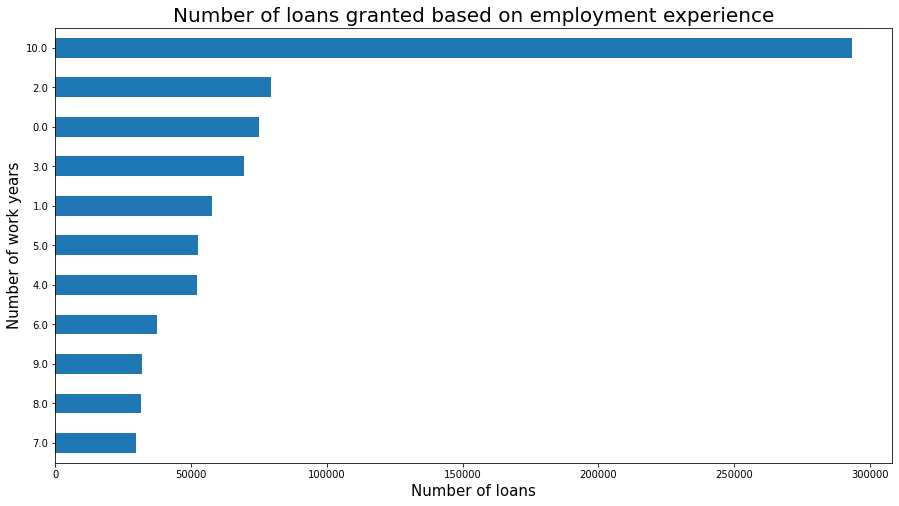

In [ ]:
df['emp_length'].value_counts().sort_values().plot(kind='barh',figsize=(15,8))
plt.title('Number of loans granted based on employment experience',fontsize=20)
plt.xlabel('Number of loans',fontsize=15)
plt.ylabel('Number of work years',fontsize=15);

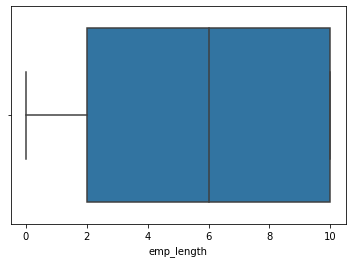

In [ ]:
# emp_length - Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
sns.boxplot(df['emp_length'])
df['emp_length'].value_counts(dropna=False)
df['emp_length'].mean()
df['emp_length'].median()
df['emp_length'] =df['emp_length'].fillna(df['emp_length'].median())

In [ ]:
#home_ownership - correcting the values to valid ones
df['home_ownership'].value_counts(dropna=False)

MORTGAGE    424568
RENT        340989
OWN         104779
ANY            500
NONE             4
Name: home_ownership, dtype: int64

In [ ]:
df['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

In [ ]:
df['home_ownership'].value_counts(dropna=False)

MORTGAGE    424568
RENT        340989
OWN         104779
OTHER          504
Name: home_ownership, dtype: int64

In [ ]:
df.info(max_cols=100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870840 entries, 0 to 870839
Data columns (total 100 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   funded_amnt                     870840 non-null  float64
 1   term                            870840 non-null  object 
 2   int_rate                        870840 non-null  float64
 3   installment                     870840 non-null  float64
 4   grade                           870840 non-null  object 
 5   sub_grade                       870840 non-null  object 
 6   emp_title                       810003 non-null  object 
 7   emp_length                      870840 non-null  float64
 8   home_ownership                  870840 non-null  object 
 9   annual_inc                      870840 non-null  float64
 10  issue_d                         870840 non-null  object 
 11  loan_status                     870840 non-null  object 
 12  pymnt_plan     

In [ ]:
df['initial_list_status'].value_counts(dropna=False)

w    672010
f    198830
Name: initial_list_status, dtype: int64

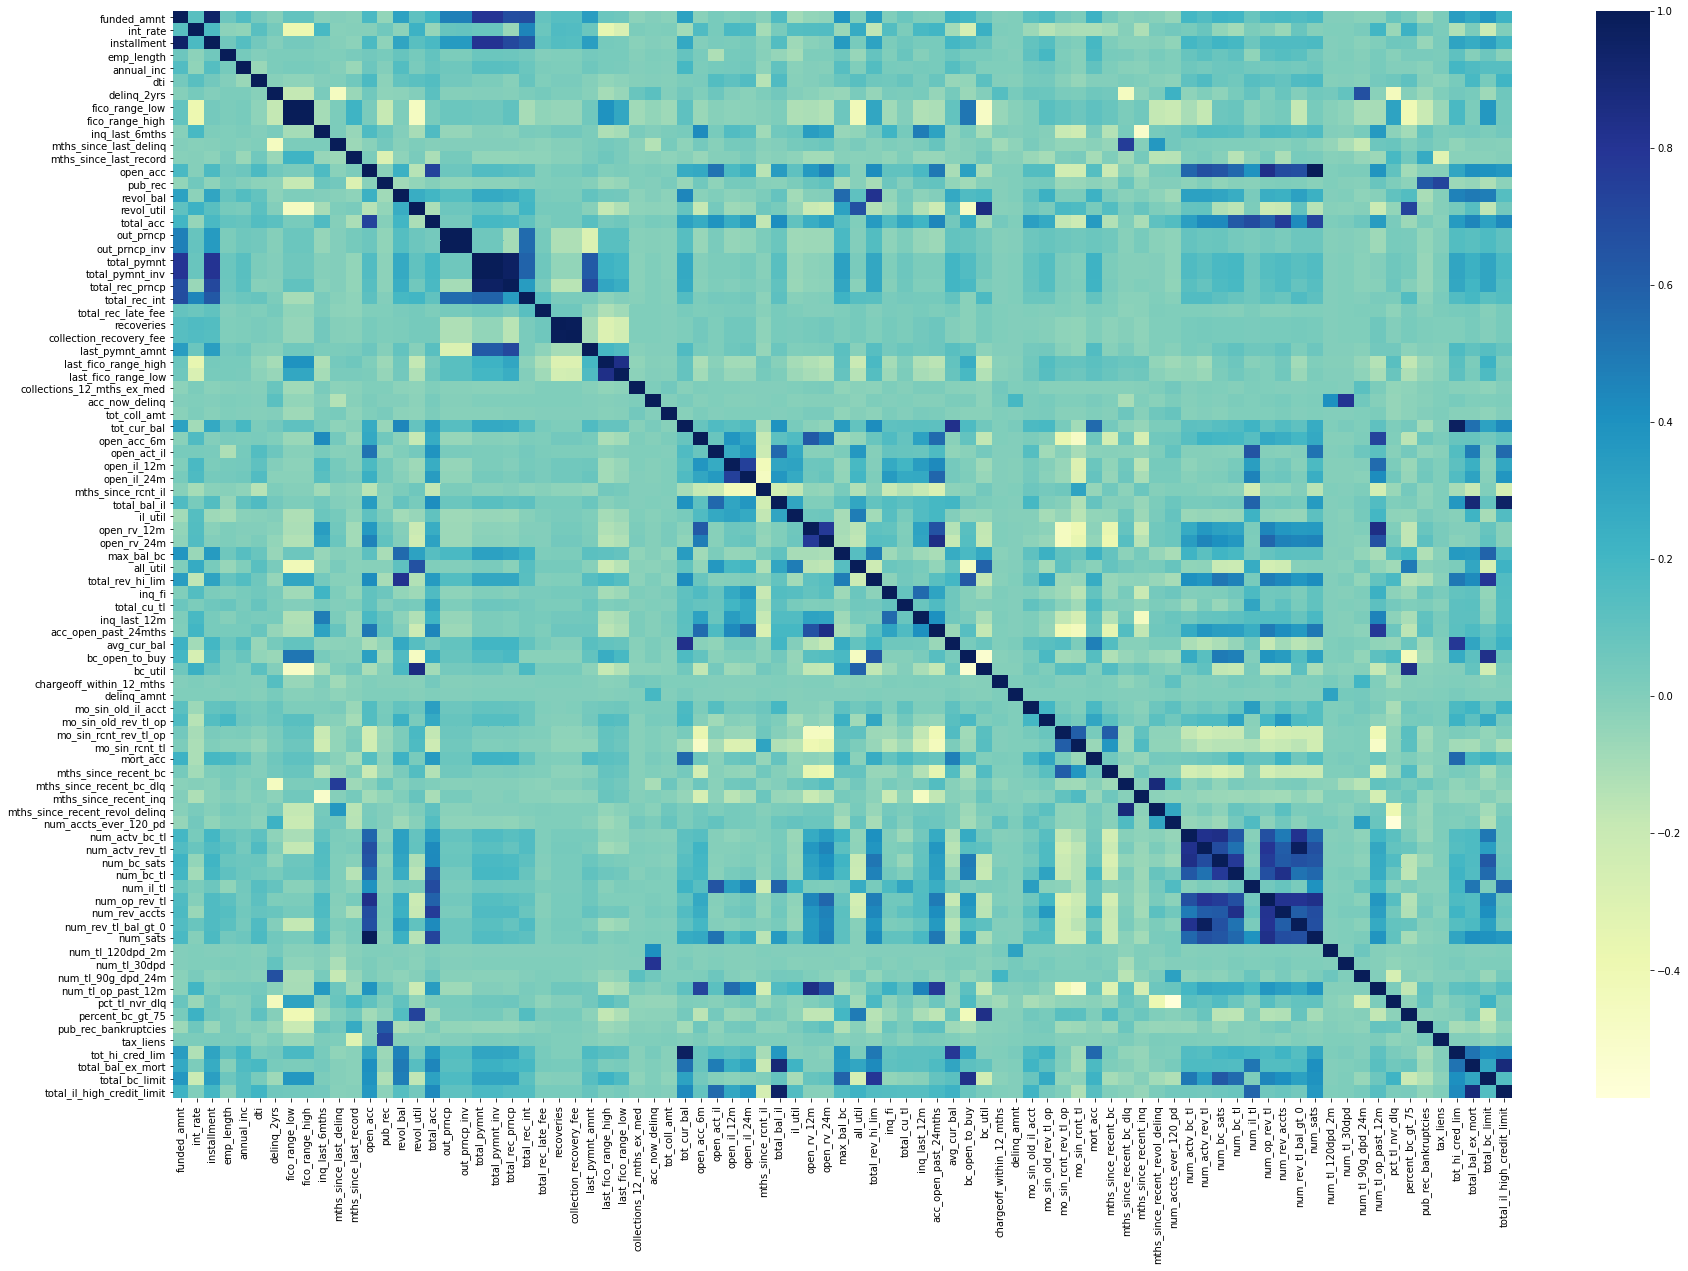

In [ ]:
# correlation and heat map
plt.figure(figsize=(30,20))
sns.heatmap(df.corr(), cmap="YlGnBu")
plt.show()

In [ ]:
df['application_type'].value_counts(dropna=False)

Individual    819833
Joint App      51007
Name: application_type, dtype: int64

In [ ]:
# removing those rows which are joint applications as we have removed related attributes for joint applications. 
# Focusing on individual applications in this analysis

ndf=df[df['application_type']=='Individual']
ndf['application_type'].value_counts(dropna=False)

Individual    819833
Name: application_type, dtype: int64

In [ ]:
ndf.shape

(819833, 100)

In [ ]:
# removing the application type column
ndf.drop(["application_type"], axis=1, inplace=True)

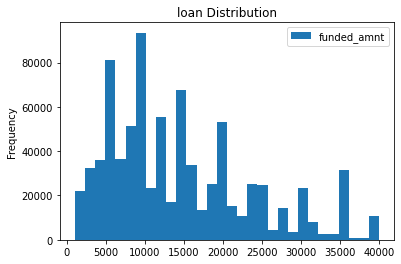

In [ ]:
ndf[['funded_amnt']].plot.hist(bins =30, title = 'loan Distribution')

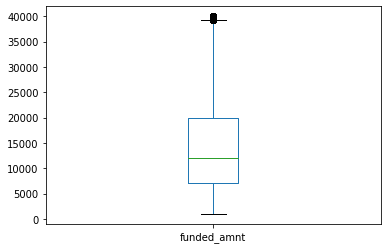

In [ ]:
ndf[['funded_amnt']].plot.box()

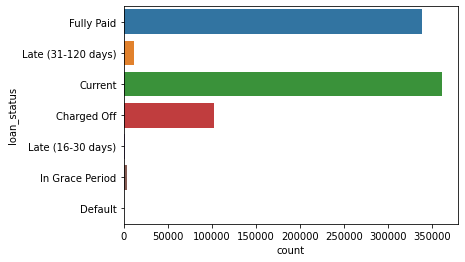

In [ ]:
 sns.countplot(y="loan_status", data=ndf)

In [ ]:
ndf['loan_status'].value_counts(dropna=False)

Current               361587
Fully Paid            338475
Charged Off           102001
Late (31-120 days)     11450
In Grace Period         4154
Late (16-30 days)       2140
Default                   26
Name: loan_status, dtype: int64

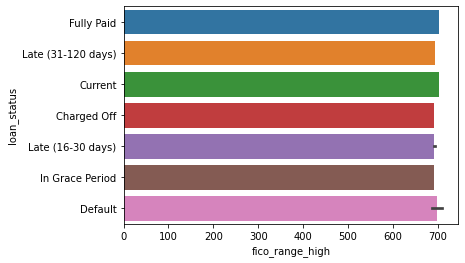

In [ ]:
sns.barplot(y="loan_status",x="fico_range_high",data=ndf)

In [ ]:
#plt.figure(figsize=(25, 15))
#plt.subplot(2,3,1)
#sns.barplot(y="loan_status",x="emp_length",data=ndf)
#plt.subplot(2,3,2)
#sns.barplot(y="loan_status",x="term",data=ndf)
#plt.subplot(2,3,3)
#sns.barplot(y="loan_status",x="int_rate",data=ndf)
#plt.subplot(2,3,4)
#sns.barplot(y="loan_status",x="fico_range_high",data=ndf)
#plt.subplot(2,3,5)
#sns.barplot(y="loan_status",x="dti",data=ndf)
#plt.subplot(2,3,6)
#sns.barplot(y="loan_status",x="fico_range_low",data=ndf)


In [ ]:
ndf.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

term                        2
grade                       7
sub_grade                  35
emp_title              191219
home_ownership              4
issue_d                    24
loan_status                 7
pymnt_plan                  2
purpose                    14
earliest_cr_line          702
initial_list_status         2
last_pymnt_d               39
next_pymnt_d                4
last_credit_pull_d         41
dtype: int64

In [ ]:
ndf['emp_title'].value_counts(dropna=False)
# almost emp_title              253709 - 2 Lakh unique values of emp_title values. We cannot encode such a long list of titles
# also, there is no much significant information with the column. Removing the column

ndf.drop(['emp_title'], axis=1, inplace=True)

In [ ]:
def is_default(x):
    if x=='Default' or x=='Late (31-120 days)' or x=='Charged Off':
        return 1
    elif x=='Fully Paid':
        return 0
    elif x=='Current' or x=='Late (16-30 days)' or x=='In Grace Period':
        return -1

In [ ]:
ndf["is_default"] = ndf["loan_status"].apply(is_default)

In [ ]:
ndf["is_default"].value_counts()

-1    367881
 0    338475
 1    113477
Name: is_default, dtype: int64

In [ ]:
ndf.shape

(819833, 99)

In [ ]:
ndf.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

term                     2
grade                    7
sub_grade               35
home_ownership           4
issue_d                 24
loan_status              7
pymnt_plan               2
purpose                 14
earliest_cr_line       702
initial_list_status      2
last_pymnt_d            39
next_pymnt_d             4
last_credit_pull_d      41
dtype: int64

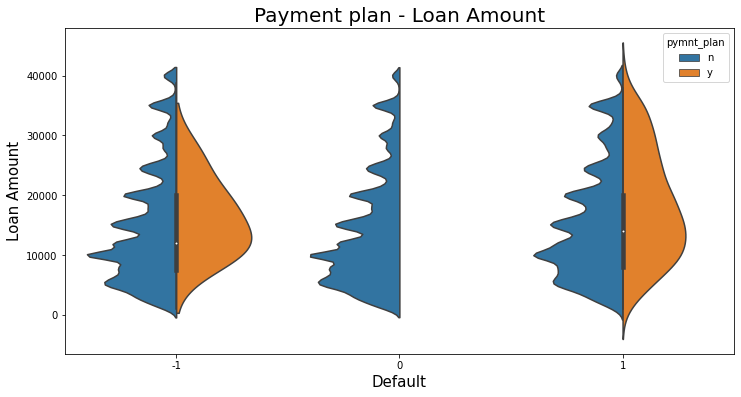

In [ ]:
fig = plt.figure(figsize=(12,6))
sns.violinplot(x="is_default",y="funded_amnt",data=ndf, hue="pymnt_plan", split=True)
plt.title("Payment plan - Loan Amount", fontsize=20)
plt.xlabel("Default", fontsize=15)
plt.ylabel("Loan Amount", fontsize=15);

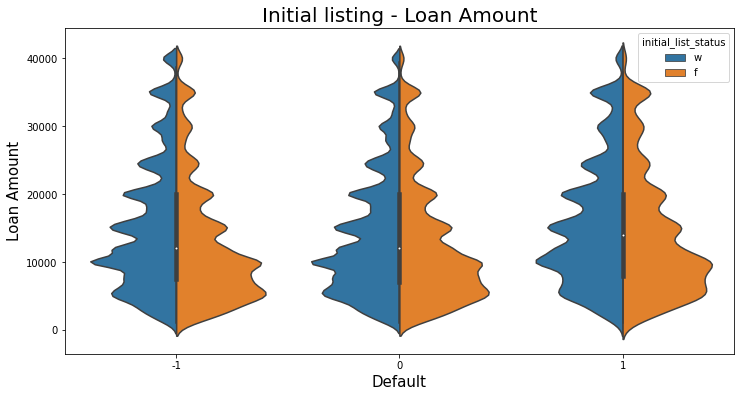

In [ ]:
fig = plt.figure(figsize=(12,6))
sns.violinplot(x="is_default",y="funded_amnt",data=ndf, hue="initial_list_status", split=True)
plt.title("Initial listing - Loan Amount", fontsize=20)
plt.xlabel("Default", fontsize=15)
plt.ylabel("Loan Amount", fontsize=15);

In [ ]:
corr = ndf.corr()['is_default'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', corr.tail(10))
print('\nMost Negative Correlations:\n', corr.head(10))

Most Positive Correlations:
 open_il_24m                0.105550
open_il_12m                0.107992
inq_last_12m               0.109646
num_tl_op_past_12m         0.126814
acc_open_past_24mths       0.138520
int_rate                   0.154711
last_pymnt_amnt            0.223212
collection_recovery_fee    0.362525
recoveries                 0.367990
is_default                 1.000000
Name: is_default, dtype: float64

Most Negative Correlations:
 out_prncp               -0.520460
out_prncp_inv           -0.520416
last_fico_range_high    -0.448687
last_fico_range_low     -0.423250
total_rec_int           -0.158640
mo_sin_rcnt_tl          -0.085391
fico_range_low          -0.079413
fico_range_high         -0.079412
mo_sin_rcnt_rev_tl_op   -0.074998
mths_since_recent_inq   -0.066520
Name: is_default, dtype: float64


<h3> Handling Datetime attributes </h3>

In [ ]:
ndf['next_pymnt_d'].value_counts(dropna=False)

NaN         440476
Apr-2019    379169
Mar-2019       158
May-2019        29
Feb-2019         1
Name: next_pymnt_d, dtype: int64

In [ ]:
ndf['next_pymnt_d'] = pd.to_datetime(ndf['next_pymnt_d'],format='%b-%Y')
ndf['last_pymnt_d'] = pd.to_datetime(ndf['last_pymnt_d'],format='%b-%Y')

In [ ]:
# dervied variable - num_mths_for_next_pymnt
def num_mths_for_next_pymnt(x):
    if x["loan_status"]=='Fully Paid' or x["loan_status"]=='Charged Off':
        return 0
    else:
        return (x["next_pymnt_d"].year - x["last_pymnt_d"].year) * 12 + x["next_pymnt_d"].month - x["last_pymnt_d"].month

In [ ]:
ndf['num_mths_for_next_pymnt']=ndf.apply(num_mths_for_next_pymnt, axis=1)


In [ ]:
ndf['num_mths_for_next_pymnt'].value_counts(dropna=False)

0    440502
1    343995
2     26835
3      3658
4      2712
5      2118
6        12
9         1
Name: num_mths_for_next_pymnt, dtype: int64

In [ ]:
ndf['num_mths_for_next_pymnt'] =ndf['num_mths_for_next_pymnt'].fillna(0)

In [ ]:
# convert earliest_cr_line date form to months since credit line opened while comparing with issue_date

# dervied variable - num_mths_for_next_pymnt
def num_mths_since_cr_line_open(x):
        return (x["issue_d"].year - x["earliest_cr_line"].year) * 12 + x["issue_d"].month - x["earliest_cr_line"].month


In [ ]:
ndf['issue_d'] = pd.to_datetime(ndf['issue_d'],format='%b-%Y')
ndf['earliest_cr_line'] = pd.to_datetime(ndf['earliest_cr_line'],format='%b-%Y')
ndf['num_mths_since_cr_line_open']=ndf.apply(num_mths_since_cr_line_open, axis=1)

In [ ]:
ndf['num_mths_since_cr_line_open'].value_counts(dropna=False)

151    5136
143    5109
152    5063
146    5060
145    5057
       ... 
682       1
732       1
758       1
711       1
784       1
Name: num_mths_since_cr_line_open, Length: 708, dtype: int64

In [ ]:
ndf['earliest_cr_line'].value_counts(dropna=False)

2004-09-01    6215
2005-09-01    6204
2004-08-01    5969
2003-09-01    5943
2005-08-01    5916
              ... 
1958-07-01       1
1957-05-01       1
1949-06-01       1
1960-05-01       1
1948-01-01       1
Name: earliest_cr_line, Length: 702, dtype: int64

In [ ]:
ndf['issue_d'].value_counts(dropna=False)

2016-03-01    59943
2017-08-01    38543
2016-02-01    38448
2016-08-01    35930
2017-07-01    35726
2017-11-01    35712
2016-04-01    35510
2017-06-01    35137
2017-05-01    35135
2017-03-01    35051
2016-07-01    34439
2016-12-01    34338
2017-09-01    33563
2016-11-01    32752
2017-12-01    32597
2016-06-01    32578
2017-10-01    32296
2016-01-01    31635
2016-10-01    31460
2017-01-01    30205
2017-04-01    27528
2016-05-01    27496
2016-09-01    27465
2017-02-01    26346
Name: issue_d, dtype: int64

In [ ]:
ndf.drop(['earliest_cr_line'], axis=1, inplace=True)

In [ ]:
ndf.drop(['issue_d'], axis=1, inplace=True)

In [ ]:
ndf.drop(['last_credit_pull_d'], axis=1, inplace=True)

In [ ]:
ndf.drop(['last_pymnt_d'], axis=1, inplace=True)

In [ ]:
ndf.info(max_cols=170)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 819833 entries, 0 to 870839
Data columns (total 97 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   funded_amnt                     819833 non-null  float64       
 1   term                            819833 non-null  object        
 2   int_rate                        819833 non-null  float64       
 3   installment                     819833 non-null  float64       
 4   grade                           819833 non-null  object        
 5   sub_grade                       819833 non-null  object        
 6   emp_length                      819833 non-null  float64       
 7   home_ownership                  819833 non-null  object        
 8   annual_inc                      819833 non-null  float64       
 9   loan_status                     819833 non-null  object        
 10  pymnt_plan                      819833 non-null  object 

In [ ]:
ndf[ndf['num_mths_for_next_pymnt'].isnull()]

,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,loan_status,pymnt_plan,purpose,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,next_pymnt_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,is_default,num_mths_for_next_pymnt,num_mths_since_cr_line_open


In [ ]:
ndf.drop(['next_pymnt_d'], axis=1, inplace=True)

In [ ]:
# check for missing values once again
total_miss_data= ndf.isnull().sum().sort_values(ascending=False)
percent_miss_data= (ndf.isnull().sum()/ndf.isnull().count()).sort_values(ascending=False)*100
missing_data= pd.concat([total_miss_data, percent_miss_data],axis=1, keys=["Total", "Percent"])
missing_data

,Total,Percent
mths_since_last_record,670158,81.743233
mths_since_recent_bc_dlq,618537,75.446707
num_mths_since_cr_line_open,0,0.000000
initial_list_status,0,0.000000
out_prncp_inv,0,0.000000
total_pymnt,0,0.000000
total_pymnt_inv,0,0.000000
total_rec_prncp,0,0.000000
total_rec_int,0,0.000000
total_rec_late_fee,0,0.000000


In [ ]:
ndf.drop(['mths_since_last_record','mths_since_recent_bc_dlq'], axis=1, inplace=True)

In [ ]:
# removing charged off records from the dataset
current_df=ndf[ndf['is_default']==-1]
f_df=ndf[ndf['is_default']!=-1]

In [ ]:
f_df['num_mths_since_cr_line_open'] = f_df['num_mths_since_cr_line_open'].astype(float)

In [ ]:
f_df.select_dtypes('float64').columns

Index(['funded_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m',
       'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
       'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',

<h3> Handling Categorical attributes </h3>

In [ ]:
f_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)


term                    2
grade                   7
sub_grade              35
home_ownership          4
loan_status             4
pymnt_plan              2
purpose                13
initial_list_status     2
dtype: int64

In [ ]:
f_df.dtypes.value_counts()

float64    84
object      8
int64       2
dtype: int64

In [ ]:
# label encoding - yes or no - 1 or 0
from sklearn import preprocessing

count = 0

for col in f_df:
    if f_df[col].dtype == 'object':
        if len(list(f_df[col].unique())) <= 2:     
            le = preprocessing.LabelEncoder()
            f_df[col] = le.fit_transform(f_df[col])
            count += 1
            print (col)
            
print('%d columns were label encoded.' % count)

term
pymnt_plan
initial_list_status
3 columns were label encoded.


In [ ]:
f_df['pymnt_plan'].value_counts()

0    451593
1       359
Name: pymnt_plan, dtype: int64

In [ ]:
f_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

grade              7
sub_grade         35
home_ownership     4
loan_status        4
purpose           13
dtype: int64

In [ ]:
f_df.drop(['loan_status'], axis=1, inplace=True)

In [ ]:
f_df = pd.get_dummies(f_df)
print(f_df.shape)

(451952, 148)


In [ ]:
f_df.info(max_cols=155)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 451952 entries, 0 to 870830
Data columns (total 148 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   funded_amnt                     451952 non-null  float64
 1   term                            451952 non-null  int64  
 2   int_rate                        451952 non-null  float64
 3   installment                     451952 non-null  float64
 4   emp_length                      451952 non-null  float64
 5   annual_inc                      451952 non-null  float64
 6   pymnt_plan                      451952 non-null  int64  
 7   dti                             451952 non-null  float64
 8   delinq_2yrs                     451952 non-null  float64
 9   fico_range_low                  451952 non-null  float64
 10  fico_range_high                 451952 non-null  float64
 11  inq_last_6mths                  451952 non-null  float64
 12  mths_since_last

In [ ]:
f_df['mths_since_recent_revol_delinq'].value_counts(dropna=False)

0.0      292617
13.0       2974
15.0       2933
12.0       2925
14.0       2816
16.0       2772
26.0       2729
18.0       2728
19.0       2726
7.0        2713
9.0        2712
11.0       2711
28.0       2689
24.0       2662
25.0       2658
17.0       2647
6.0        2646
22.0       2618
20.0       2576
8.0        2567
21.0       2558
30.0       2539
27.0       2522
10.0       2516
23.0       2507
5.0        2495
29.0       2495
31.0       2462
33.0       2370
32.0       2361
34.0       2357
37.0       2348
39.0       2344
38.0       2337
35.0       2323
36.0       2322
40.0       2260
43.0       2234
41.0       2223
42.0       2181
44.0       2173
4.0        2165
47.0       2158
46.0       2069
45.0       2065
48.0       2034
3.0        1896
49.0       1791
2.0        1464
74.0       1437
73.0       1425
72.0       1353
75.0       1340
76.0       1325
71.0       1305
68.0       1284
69.0       1278
70.0       1259
1.0        1259
62.0       1246
67.0       1238
51.0       1229
65.0    

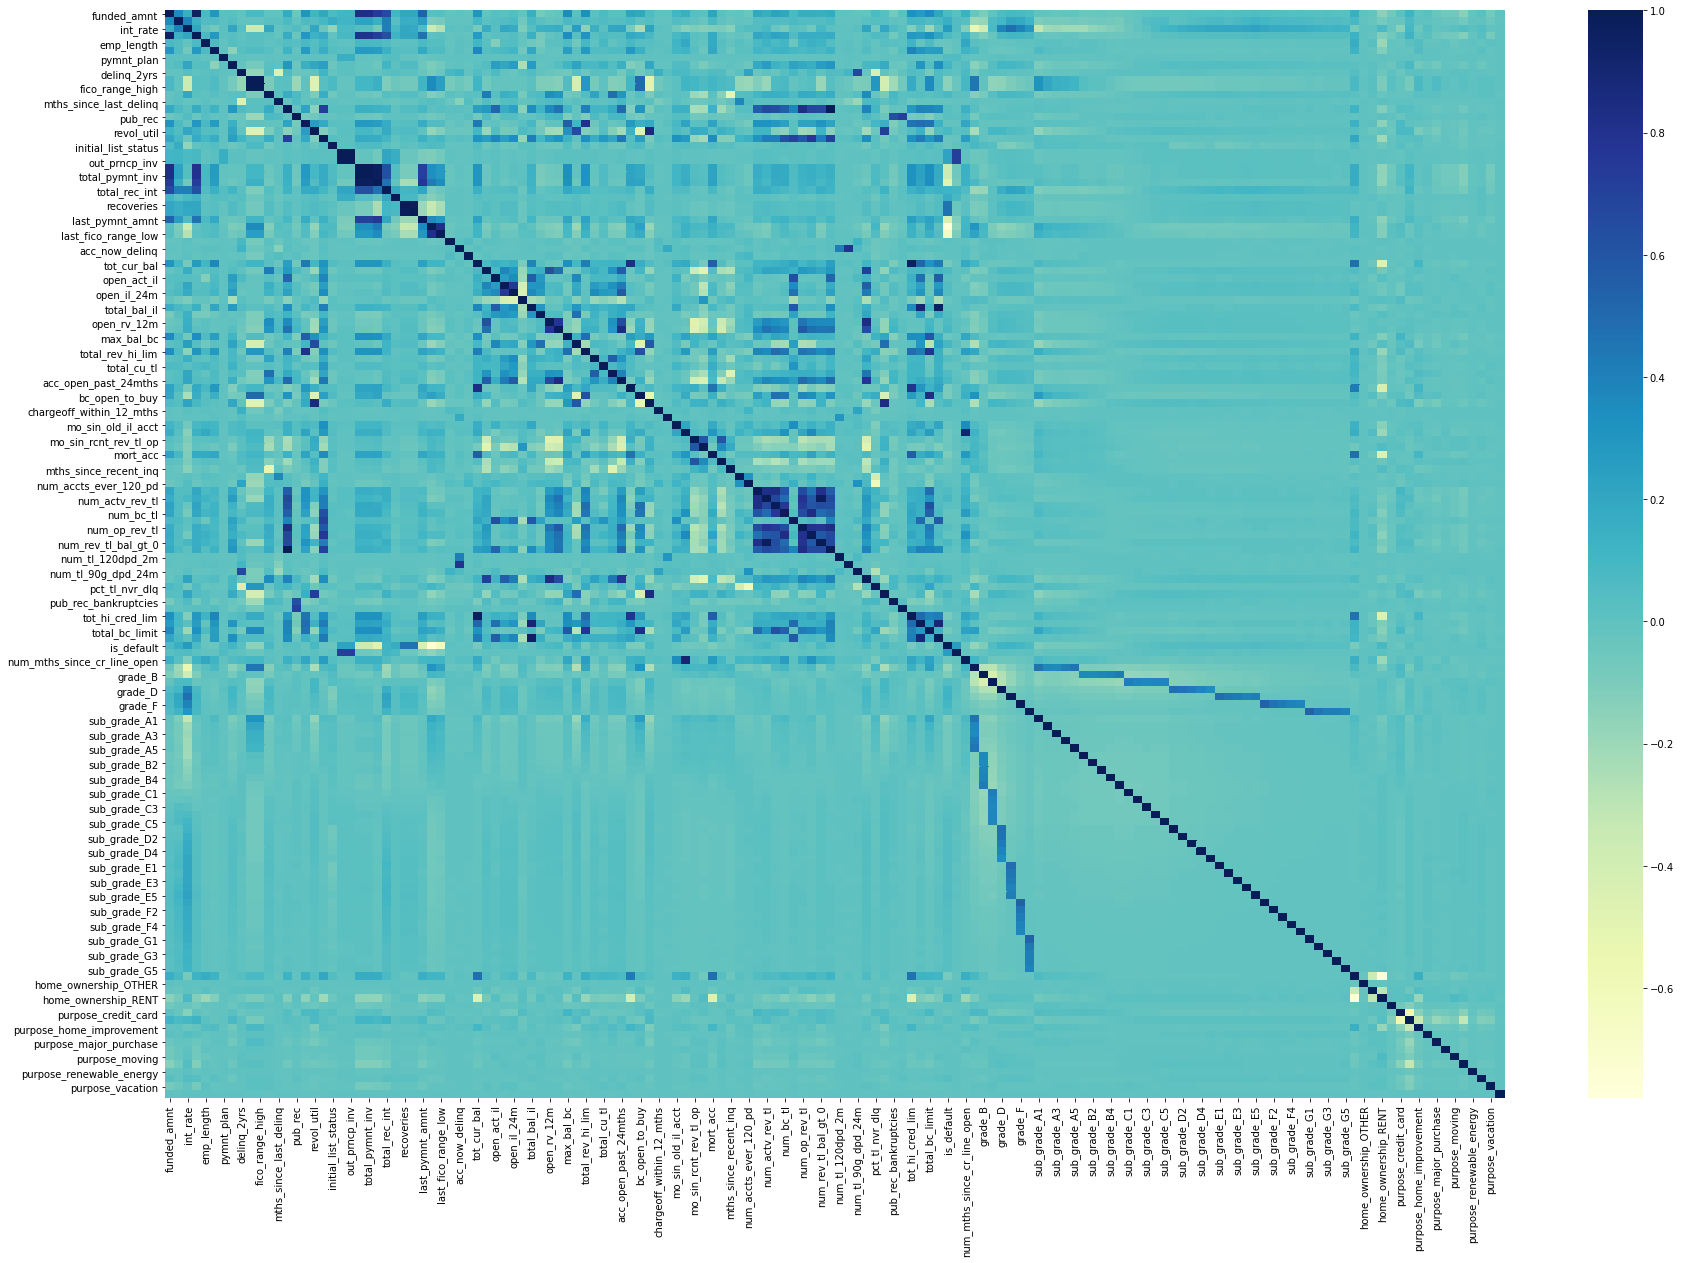

In [ ]:
# correlation and heat map
plt.figure(figsize=(30,20))
sns.heatmap(f_df.corr(), cmap="YlGnBu")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(f_df.drop('is_default',axis=1),f_df['is_default'],test_size=0.15,random_state=101)

In [ ]:
X_train.info(max_cols=160)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384159 entries, 295353 to 237487
Data columns (total 147 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   funded_amnt                     384159 non-null  float64
 1   term                            384159 non-null  int64  
 2   int_rate                        384159 non-null  float64
 3   installment                     384159 non-null  float64
 4   emp_length                      384159 non-null  float64
 5   annual_inc                      384159 non-null  float64
 6   pymnt_plan                      384159 non-null  int64  
 7   dti                             384159 non-null  float64
 8   delinq_2yrs                     384159 non-null  float64
 9   fico_range_low                  384159 non-null  float64
 10  fico_range_high                 384159 non-null  float64
 11  inq_last_6mths                  384159 non-null  float64
 12  mths_since

In [ ]:
X_train.head()

,funded_amnt,term,int_rate,installment,emp_length,annual_inc,pymnt_plan,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,num_mths_for_next_pymnt,num_mths_since_cr_line_open,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
295353,20000.0,0,17.99,722.95,10.0,83200.0,0,30.49,0.0,670.0,674.0,1.0,30.0,12.0,0.0,32517.0,83.2,40.0,1,0.0,0.0,20516.110000,20516.11,20000.00,516.11,0.0,0.0,0.00,3128.07,789.0,785.0,0.0,0.0,0.0,52224.0,0.0,4.0,1.0,4.0,10.0,19707.0,54.0,0.0,2.0,9247.0,69.0,39100.0,4.0,0.0,3.0,6.0,4352.0,4783.0,87.2,0.0,0.0,126.0,211.0,17.0,10.0,4.0,17.0,5.0,0.0,0.0,7.0,7.0,7.0,7.0,16.0,8.0,20.0,7.0,12.0,0.0,0.0,0.0,1.0,100.0,71.4,0.0,0.0,75301.0,52224.0,37300.0,36201.0,0,212.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
597180,30000.0,0,7.35,931.13,10.0,100000.0,0,16.99,1.0,740.0,744.0,0.0,15.0,15.0,0.0,34529.0,50.6,24.0,1,0.0,0.0,32540.848565,32540.85,30000.00,2540.85,0.0,0.0,0.00,17655.02,694.0,690.0,0.0,0.0,0.0,76096.0,1.0,1.0,0.0,0.0,33.0,11586.0,49.0,1.0,1.0,10265.0,50.0,68300.0,0.0,2.0,0.0,1.0,5435.0,23539.0,55.9,0.0,0.0,116.0,182.0,5.0,5.0,4.0,5.0,5.0,15.0,0.0,6.0,10.0,7.0,9.0,4.0,13.0,16.0,10.0,15.0,0.0,0.0,0.0,1.0,95.7,28.6,0.0,0.0,138432.0,46115.0,53400.0,23482.0,0,182.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
251194,3500.0,0,24.49,138.22,3.0,48000.0,0,20.08,1.0,670.0,674.0,1.0,11.0,16.0,0.0,10321.0,51.1,23.0,0,0.0,0.0,2594.140000,2594.14,204.49,200.65,0.0,2189.0,394.02,138.22,589.0,585.0,0.0,0.0,0.0,43451.0,2.0,6.0,0.0,1.0,18.0,33130.0,94.0,5.0,8.0,2689.0,78.0,20200.0,1.0,0.0,2.0,9.0,2716.0,8303.0,50.6,0.0,0.0,116.0,155.0,2.0,2.0,0.0,2.0,2.0,11.0,4.0,7.0,10.0,7.0,9.0,11.0,10.0,12.0,10.0,16.0,0.0,0.0,0.0,5.0,68.2,42.9,0.0,0.0,55563.0,43451.0,16800.0,35363.0,0,155.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
45959,10000.0,0,6.49,306.45,10.0,40500.0,0,16.71,0.0,815.0,819.0,1.0,30.0,11.0,0.0,3

<h3> Standardising values </h3>

In [ ]:
# Standardising values:
from sklearn import preprocessing
sc = preprocessing.MinMaxScaler()
# Fit your data on the scaler object

var_col=f_df.select_dtypes('float64').columns

In [ ]:
print(var_col)

Index(['funded_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m',
       'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
       'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',

In [ ]:
X_train[var_col] = sc.fit_transform(X_train[var_col])
X_train.head()

#scaled_df = sc.fit_transform(sdf)
#scaled_df = pd.DataFrame(scaled_df, columns=s_columns)

,funded_amnt,term,int_rate,installment,emp_length,annual_inc,pymnt_plan,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,num_mths_for_next_pymnt,num_mths_since_cr_line_open,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
295353,0.487179,0,0.493572,0.410029,1.0,0.007384,0,0.617936,0.000000,0.054054,0.053763,0.2,0.156250,0.126437,0.000000,0.019164,0.483721,0.218391,1,0.0,0.0,0.339650,0.339649,0.500000,0.022202,0.0,0.000000,0.000000,0.074139,0.928235,0.928994,0.0,0.0,0.0,0.009591,0.000000,0.075472,0.047619,0.102564,0.019569,0.011518,0.096774,0.000000,0.037736,0.011903,0.348485,0.023658,0.142857,0.000000,0.061224,0.111111,0.009385,0.010516,0.345620,0.0,0.0,0.126126,0.245882,0.038813,0.031847,0.078431,0.026604,0.20,0.000000,0.000000,0.212121,0.116667,0.142857,0.100000,0.100629,0.103896,0.142857,0.166667,0.137931,0.0,0.0,0.0,0.03125,1.000,0.714,0.0,0.0,0.007530,0.015324,0.033740,0.020852,0,0.181913,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
597180,0.743590,0,0.079081,0.533234,1.0,0.008911,0,0.353022,0.027778,0.432432,0.430108,0.0,0.078125,0.160920,0.000000,0.020350,0.294186,0.126437,1,0.0,0.0,0.538722,0.538722,0.750000,0.109301,0.0,0.000000,0.000000,0.418444,0.816471,0.816568,0.0,0.0,0.0,0.013975,0.055556,0.018868,0.000000,0.000000,0.064579,0.006771,0.087814,0.035714,0.018868,0.013214,0.252525,0.041326,0.000000,0.025316,0.000000,0.018519,0.011721,0.051752,0.221562,0.0,0.0,0.116116,0.211765,0.011416,0.015924,0.078431,0.007825,0.20,0.076142,0.000000,0.181818,0.166667,0.142857,0.128571,0.025157,0.168831,0.111111,0.238095,0.172414,0.0,0.0,0.0,0.03125,0.957,0.286,0.0,0.0,0.013843,0.013531,0.048304,0.013526,0,0.150728,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
251194,0.064103,0,0.746786,0.063975,0.3,0.004183,0,0.413658,0.027778,0.054054,0.053763,0.2,0.057292,0.172414,0.000000,0.006083,0.297093,0.120690,0,0.0,0.0,0.042947,0.042947,0.005112,0.008631,0.0,0.058918,0.058918,0.003276,0.692941,0

In [ ]:
X_test[var_col] = sc.transform(X_test[var_col])

In [ ]:
X_test.head()

,funded_amnt,term,int_rate,installment,emp_length,annual_inc,pymnt_plan,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,num_mths_for_next_pymnt,num_mths_since_cr_line_open,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
98472,0.615385,0,0.100117,0.445065,1.0,0.007093,0,0.579278,0.0,0.243243,0.241935,0.0,0.156250,0.275862,0.0,0.013257,0.263953,0.252874,1,0.0,0.0,0.458733,0.458733,0.625,0.116542,0.0,0.0,0.0,0.242316,0.916471,0.917160,0.000000,0.0,0.000057,0.042944,0.000000,0.094340,0.000000,0.051282,0.043053,0.026857,0.077061,0.071429,0.056604,0.010456,0.222222,0.030011,0.214286,0.101266,0.020408,0.092593,0.021012,0.041030,0.205311,0.0,0.0,0.258258,0.170588,0.018265,0.025478,0.058824,0.012520,0.28,0.000000,0.000000,0.242424,0.166667,0.265306,0.228571,0.125786,0.246753,0.166667,0.238095,0.287356,0.0,0.0,0.0,0.06250,1.000,0.231,0.0,0.0,0.030432,0.020084,0.035007,0.045358,0,0.229730,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
196753,0.358974,0,0.149981,0.265176,1.0,0.023461,0,0.233909,0.0,0.000000,0.000000,0.4,0.203125,0.160920,0.0,0.032455,0.470930,0.155172,1,0.0,0.0,0.278957,0.278957,0.375,0.079585,0.0,0.0,0.0,0.062693,0.892941,0.893491,0.000000,0.0,0.000000,0.112872,0.055556,0.075472,0.047619,0.076923,0.009785,0.015834,0.100358,0.035714,0.018868,0.028988,0.409091,0.041278,0.035714,0.000000,0.040816,0.074074,0.088359,0.016001,0.325010,0.0,0.0,0.108108,0.340000,0.025114,0.015924,0.039216,0.039124,0.00,0.000000,0.000000,0.242424,0.166667,0.224490,0.157143,0.075472,0.129870,0.103175,0.238095,0.172414,0.0,0.0,0.0,0.06250,0.970,0.375,0.0,0.0,0.056576,0.024108,0.052664,0.028072,0,0.264033,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
387349,0.871795,0,0.240358,0.665132,0.5,0.016641,0,0.201334,0.0,0.189189,0.188172,0.2,0.156250,0.114943,0.0,0.019307,0.440698,0.109195,0,0.0,0.0,0.668200,0.668200,0.875,0.230650,0.0,0.0,0.0,0.410128,0.804706,0.804734,0.000000,0.0,0.000000,0.048692,0.055556,0.

In [ ]:
# Apply PCA first - for dimensionality reduction
#Importing the PCA module

from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

#Doing the PCA on the train data
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=False)

In [ ]:
pca.components_

array([[-9.57411420e-02, -8.50844317e-02,  4.44819718e-02, ...,
         2.80943418e-03,  3.71621270e-03, -3.19645234e-06],
       [ 9.70707975e-02,  2.64808065e-01,  1.66840202e-01, ...,
        -2.10526631e-03, -5.40336574e-03,  3.38861574e-06],
       [-4.83674583e-02, -3.18604601e-02, -2.88243538e-02, ...,
         1.07158895e-02,  9.30210709e-03,  5.26105379e-06],
       ...,
       [-0.00000000e+00,  4.33361217e-17, -1.70632896e-16, ...,
         4.48949443e-02,  4.48949443e-02,  4.48949443e-02],
       [ 0.00000000e+00,  5.97273271e-17, -3.50643428e-17, ...,
        -2.86567213e-02, -2.86567213e-02, -2.86567213e-02],
       [ 0.00000000e+00,  5.19037948e-17,  5.07978164e-17, ...,
         4.48877383e-02,  4.48877383e-02,  4.48877383e-02]])

In [ ]:
colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head()

,PC1,PC2,Feature
0,-0.095741,0.097071,funded_amnt
1,-0.085084,0.264808,term
2,0.044482,0.166840,int_rate
3,-0.056451,0.059538,installment
4,-0.141180,0.024096,emp_length


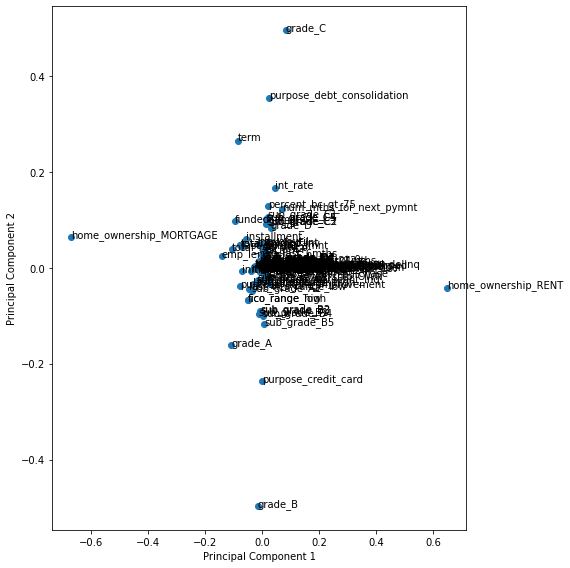

In [ ]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

In [ ]:
pca.explained_variance_ratio_

array([1.03860639e-01, 8.83173695e-02, 7.30945528e-02, 6.63933712e-02,
       5.85362863e-02, 5.48693556e-02, 4.95908714e-02, 3.66477465e-02,
       3.64650152e-02, 3.36692814e-02, 2.70848819e-02, 2.68190100e-02,
       2.32509144e-02, 1.82234449e-02, 1.54126774e-02, 1.51668189e-02,
       1.49253189e-02, 1.34561376e-02, 1.31350230e-02, 1.30339928e-02,
       1.27326861e-02, 1.24820760e-02, 1.19617466e-02, 1.17503671e-02,
       9.79533629e-03, 8.85026638e-03, 8.15351004e-03, 7.72241470e-03,
       7.68637484e-03, 7.62799792e-03, 7.23515131e-03, 6.99635922e-03,
       6.81453470e-03, 6.29777023e-03, 5.68845831e-03, 5.66639399e-03,
       4.88702377e-03, 4.52061167e-03, 4.32941821e-03, 4.00046070e-03,
       3.66205165e-03, 3.49877398e-03, 3.31229032e-03, 3.02871861e-03,
       2.93812114e-03, 2.82043229e-03, 2.76229671e-03, 2.54204378e-03,
       2.51855792e-03, 2.48315964e-03, 2.36733321e-03, 2.26801175e-03,
       2.05197208e-03, 1.92117317e-03, 1.85499158e-03, 1.77797585e-03,
      

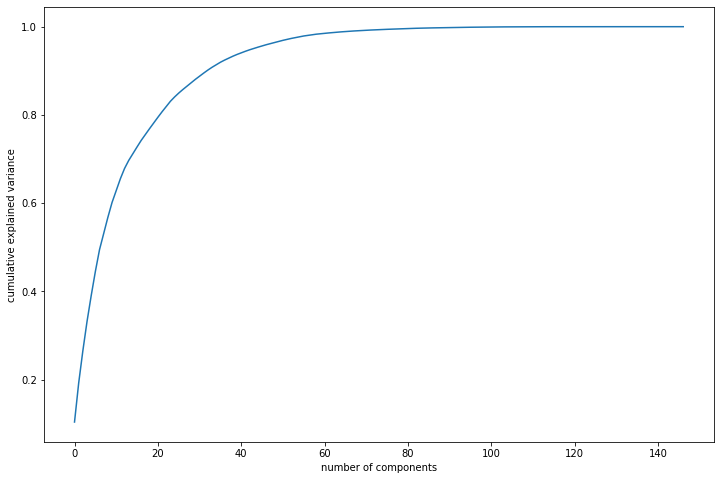

In [ ]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [ ]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=35)

df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape

(384159, 35)

In [ ]:
corrmat = np.corrcoef(df_train_pca.transpose())

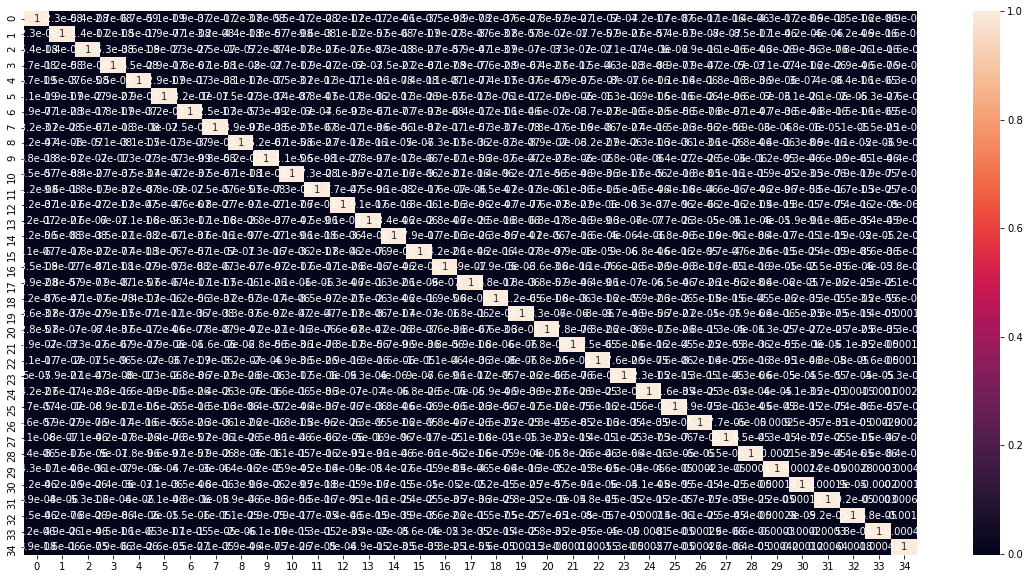

In [ ]:
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

In [ ]:
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(67793, 35)

<h3>Without handling class imbalancing </h3>

In [ ]:
def build_model(samp_model,X_train,y_train):
  model=samp_model.fit(X_train,y_train)
  return model

In [ ]:
def print_metrics(y_train, y_test, y_train_pred, y_test_pred, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, y_train_pred)))
        print("Classification Report: \n {}\n".format(classification_report(y_train, y_train_pred)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, y_train_pred)))
        #res = cross_val_score(samp_model, X_train, y_train, cv=10, scoring='accuracy')
        #print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        #print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, y_test_pred)))
        print("Classification Report: \n {}\n".format(classification_report(y_test, y_test_pred)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, y_test_pred)))
        print('ROC-AUC score:',roc_auc_score(y_test, y_test_pred))

<h3>Building Logistic Regression model </h3>

In [ ]:
lr=LogisticRegression()
lr_model=build_model(lr,df_train_pca, y_train)

In [ ]:
# Traning metrics
y_train_pred = lr_model.predict(df_train_pca)
y_test_pred = lr_model.predict(df_test_pca)
print_metrics(y_train, y_test,y_train_pred,y_test_pred,train=True)

Train Result:

accuracy score: 0.9821

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    287768
           1       0.97      0.96      0.96     96391

    accuracy                           0.98    384159
   macro avg       0.98      0.98      0.98    384159
weighted avg       0.98      0.98      0.98    384159


Confusion Matrix: 
 [[284477   3291]
 [  3573  92818]]



In [ ]:
# Test metrics
print_metrics(y_train, y_test,y_train_pred,y_test_pred,train=False)

Test Result:

accuracy score: 0.9815

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     50707
           1       0.96      0.96      0.96     17086

    accuracy                           0.98     67793
   macro avg       0.98      0.98      0.98     67793
weighted avg       0.98      0.98      0.98     67793


Confusion Matrix: 
 [[50101   606]
 [  646 16440]]

ROC-AUC score: 0.9751201275119292


<h3>Building Random Forest model </h3>

In [ ]:
rfc = RandomForestClassifier()
rfc_model=build_model(rfc,df_train_pca, y_train)

In [ ]:
# Traning metrics
y_train_pred_rfc = rfc_model.predict(df_train_pca)
y_test_pred_rfc = rfc_model.predict(df_test_pca)
print_metrics(y_train, y_test, y_train_pred_rfc, y_test_pred_rfc, train=True)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    287768
           1       1.00      1.00      1.00     96391

    accuracy                           1.00    384159
   macro avg       1.00      1.00      1.00    384159
weighted avg       1.00      1.00      1.00    384159


Confusion Matrix: 
 [[287768      0]
 [     1  96390]]



In [ ]:
# Test metrics
print_metrics(y_train, y_test, y_train_pred_rfc, y_test_pred_rfc, train=False)

Test Result:

accuracy score: 0.9730

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     50707
           1       0.96      0.93      0.95     17086

    accuracy                           0.97     67793
   macro avg       0.97      0.96      0.96     67793
weighted avg       0.97      0.97      0.97     67793


Confusion Matrix: 
 [[50099   608]
 [ 1225 15861]]

ROC-AUC score: 0.9581567097751894


<h3> Handling Class imbalancing with SMOTE Oversampling technique</h3> 

In [ ]:
# Oversampling with SMOTE - handling class imbalancing
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12)
df_train_pca_r, y_train_r = sm.fit_resample(df_train_pca, y_train)

<h3> Building Model - Logistic Regression </h3>

In [ ]:
#Training the model on the train data
lr_os = LogisticRegression()
lr_os_model = build_model(lr_os,df_train_pca_r,y_train_r)

In [ ]:
# Traning metrics
y_train_pred_lr_os = lr_os_model.predict(df_train_pca_r)
y_test_pred_lr_os = lr_os_model.predict(df_test_pca)
print_metrics(y_train_r, y_test, y_train_pred_lr_os, y_test_pred_lr_os, train=True)

Train Result:

accuracy score: 0.9834

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98    287768
           1       0.98      0.99      0.98    287768

    accuracy                           0.98    575536
   macro avg       0.98      0.98      0.98    575536
weighted avg       0.98      0.98      0.98    575536


Confusion Matrix: 
 [[282432   5336]
 [  4203 283565]]



In [ ]:
# Testing metrics
print_metrics(y_train_r, y_test, y_train_pred_lr_os, y_test_pred_lr_os, train=False)

Test Result:

accuracy score: 0.9804

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     50707
           1       0.95      0.98      0.96     17086

    accuracy                           0.98     67793
   macro avg       0.97      0.98      0.97     67793
weighted avg       0.98      0.98      0.98     67793


Confusion Matrix: 
 [[49757   950]
 [  378 16708]]

ROC-AUC score: 0.9795707691255712


<h3> Model - Random forests classifier - with default hyper parameters </h3>

In [ ]:
# Running the random forest with default parameters.
rfc_os = RandomForestClassifier()

In [ ]:
# fit
rfc_os_model=rfc_os.fit(df_train_pca_r,y_train_r)

In [ ]:
y_train_pred_rfc_os = rfc_os_model.predict(df_train_pca_r)
y_test_pred_rfc_os = rfc_os_model.predict(df_test_pca)
print_metrics(y_train_r, y_test, y_train_pred_rfc_os, y_test_pred_rfc_os, train=True)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    287768
           1       1.00      1.00      1.00    287768

    accuracy                           1.00    575536
   macro avg       1.00      1.00      1.00    575536
weighted avg       1.00      1.00      1.00    575536


Confusion Matrix: 
 [[287766      2]
 [     0 287768]]



In [ ]:
print_metrics(y_train_r, y_test, y_train_pred_rfc_os, y_test_pred_rfc_os, train=False)

Test Result:

accuracy score: 0.9733

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     50707
           1       0.94      0.95      0.95     17086

    accuracy                           0.97     67793
   macro avg       0.96      0.97      0.96     67793
weighted avg       0.97      0.97      0.97     67793


Confusion Matrix: 
 [[49698  1009]
 [  801 16285]]

ROC-AUC score: 0.9666104398634169


<h3>Random Forests Hyper parameter finetuning </h3>

In [ ]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="precision")
rf.fit(X_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training prec")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test prec")
plt.xlabel("max_depth")
plt.ylabel("precision")
plt.legend()
plt.show()


In [ ]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(100, 1500, 400)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=4)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# GridSearchCV to find optimal max_features
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20, 24]}

# instantiate the model
rf = RandomForestClassifier(max_depth=4)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(100, 400, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(200, 500, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200, 300], 
    'max_features': [5, 10]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

In [ ]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

In [ ]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=10,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=10,
                             n_estimators=100)

In [ ]:
# fit
rfc.fit(X_train,y_train)

In [ ]:
# predict
predictions = rfc.predict(X_test)

In [ ]:
print_metrics(rfc_os, df_train_pca_r, y_train_r, df_test_pca, y_test, train=True)

In [ ]:
print_metrics(rfc_os, df_train_pca_r, y_train_r, df_test_pca, y_test, train=False)

<h3>With Class imbalance handling - Tomek Links - Under sampling techniques </h3>

In [ ]:
from imblearn.under_sampling import TomekLinks
tl = TomekLinks(sampling_strategy='majority')
df_train_r_tl, y_train_r_tl = sm.fit_resample(df_train_pca, y_train)

<h3> Building Logistic Regression </h3>

In [ ]:
#Training the model on the train data
lr_tl = LogisticRegression()
lr_tl_model = build_model(lr_tl,df_train_r_tl, y_train_r_tl)

In [ ]:
y_train_pred_lr_tl = lr_tl_model.predict(df_train_r_tl)
y_test_pred_lr_tl = lr_tl_model.predict(df_test_pca)
print_metrics(y_train_r_tl, y_test, y_train_pred_lr_tl, y_test_pred_lr_tl, train=True)

Train Result:

accuracy score: 0.9834

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98    287768
           1       0.98      0.99      0.98    287768

    accuracy                           0.98    575536
   macro avg       0.98      0.98      0.98    575536
weighted avg       0.98      0.98      0.98    575536


Confusion Matrix: 
 [[282432   5336]
 [  4203 283565]]



In [ ]:
print_metrics(y_train_r_tl, y_test, y_train_pred_lr_tl, y_test_pred_lr_tl, train=False)

Test Result:

accuracy score: 0.9804

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     50707
           1       0.95      0.98      0.96     17086

    accuracy                           0.98     67793
   macro avg       0.97      0.98      0.97     67793
weighted avg       0.98      0.98      0.98     67793


Confusion Matrix: 
 [[49757   950]
 [  378 16708]]

ROC-AUC score: 0.9795707691255712


<h3> Building Random Forest model </h3>

In [ ]:
# default model
rfc_tl = RandomForestClassifier()
rfc_tl_model=build_model(rfc_tl,df_train_r_tl, y_train_r_tl)

In [ ]:
y_train_pred_rfc_tl = rfc_tl_model.predict(df_train_r_tl)
y_test_pred_rfc_tl = rfc_tl_model.predict(df_test_pca)
print_metrics(y_train_r_tl, y_test, y_train_pred_rfc_tl, y_test_pred_rfc_tl, train=True)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    287768
           1       1.00      1.00      1.00    287768

    accuracy                           1.00    575536
   macro avg       1.00      1.00      1.00    575536
weighted avg       1.00      1.00      1.00    575536


Confusion Matrix: 
 [[287766      2]
 [     0 287768]]



In [ ]:
print_metrics(y_train_r_tl, y_test, y_train_pred_rfc_tl, y_test_pred_rfc_tl, train=False)

Test Result:

accuracy score: 0.9735

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     50707
           1       0.94      0.95      0.95     17086

    accuracy                           0.97     67793
   macro avg       0.96      0.97      0.96     67793
weighted avg       0.97      0.97      0.97     67793


Confusion Matrix: 
 [[49709   998]
 [  800 16286]]

ROC-AUC score: 0.9667481698748096


<h3> Handling Class imbalancing with NearMiss undersampling technique </h3>

In [ ]:
from imblearn.under_sampling import NearMiss
nm = NearMiss(sampling_strategy='majority')
df_train_us_nm, y_train_us_nm = sm.fit_resample(df_train_pca, y_train)

<h3> Building Logistic Regression </h3>

In [ ]:
#Training the model on the train data
lr_nm = LogisticRegression()
lr_nm_model = build_model(lr_nm,df_train_us_nm, y_train_us_nm)

In [ ]:
y_train_pred_lr_nm = lr_nm_model.predict(df_train_us_nm)
y_test_pred_lr_nm = lr_nm_model.predict(df_test_pca)
print_metrics(y_train_us_nm, y_test, y_train_pred_lr_nm, y_test_pred_lr_nm, train=True)


Train Result:

accuracy score: 0.9834

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98    287768
           1       0.98      0.99      0.98    287768

    accuracy                           0.98    575536
   macro avg       0.98      0.98      0.98    575536
weighted avg       0.98      0.98      0.98    575536


Confusion Matrix: 
 [[282432   5336]
 [  4203 283565]]



In [ ]:
print_metrics(y_train_us_nm, y_test, y_train_pred_lr_nm, y_test_pred_lr_nm, train=False)

Test Result:

accuracy score: 0.9804

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     50707
           1       0.95      0.98      0.96     17086

    accuracy                           0.98     67793
   macro avg       0.97      0.98      0.97     67793
weighted avg       0.98      0.98      0.98     67793


Confusion Matrix: 
 [[49757   950]
 [  378 16708]]

ROC-AUC score: 0.9795707691255712


<h3> Building Random Forest model </h3>

In [ ]:
#Training the model on the train data
rfc_nm = RandomForestClassifier()
rfc_nm_model = build_model(rfc_nm,df_train_us_nm, y_train_us_nm)

In [ ]:
y_train_pred_rfc_nm = rfc_nm_model.predict(df_train_us_nm)
y_test_pred_rfc_nm = rfc_nm_model.predict(df_test_pca)
print_metrics(y_train_us_nm, y_test, y_train_pred_rfc_nm, y_test_pred_rfc_nm, train=True)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    287768
           1       1.00      1.00      1.00    287768

    accuracy                           1.00    575536
   macro avg       1.00      1.00      1.00    575536
weighted avg       1.00      1.00      1.00    575536


Confusion Matrix: 
 [[287768      0]
 [     0 287768]]



In [ ]:
print_metrics(y_train_us_nm, y_test, y_train_pred_rfc_nm, y_test_pred_rfc_nm, train=False)

Test Result:

accuracy score: 0.9733

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     50707
           1       0.94      0.95      0.95     17086

    accuracy                           0.97     67793
   macro avg       0.96      0.97      0.96     67793
weighted avg       0.97      0.97      0.97     67793


Confusion Matrix: 
 [[49709   998]
 [  812 16274]]

ROC-AUC score: 0.9663970051785672


<h3> Feature selection using CFS </h3>

<h3>Feature selection using Relief <h3>

<h3> Feature selection using IFS </h3>

<h3> Model - Support vector machines </h3>

In [ ]:
from sklearn import svm
from sklearn import metrics

# an initial SVM model with linear kernel   
svm_linear = svm.SVC(kernel='linear')

In [ ]:
# fit
svm_linear.fit(df_train_pca_r, y_train_r)

In [ ]:
print_metrics(svm_linear, df_train_pca_r, y_train_r, df_test_pca, y_test, train=True)

In [ ]:
print_metrics(svm_linear, df_train_pca_r, y_train_r, df_test_pca, y_test, train=False)

In [ ]:
# run gc.collect() (garbage collect) to free up memory
# else, since the dataset is large and SVM is computationally heavy,
# it'll throw a memory error while training
import gc
gc.collect()

7709

In [ ]:
# Non-linear SVM
# rbf kernel with other hyperparameters kept to default 
svm_rbf = svm.SVC(kernel='rbf')
svm_rbf.fit(x_train, y_train)

In [ ]:
# Training metrics
print_metrics(svm_linear, df_train_pca_r, y_train_r, df_test_pca, y_test, train=True)

In [ ]:
# Testing metrics
print_metrics(svm_linear, df_train_pca_r, y_train_r, df_test_pca, y_test, train=False)

In [ ]:
# conduct (grid search) cross-validation to find the optimal values 
# of cost C and the choice of kernel

from sklearn.model_selection import GridSearchCV

parameters = {'C':[1, 10, 100], 
             'gamma': [1e-2, 1e-3, 1e-4]}

# instantiate a model 
svc_grid_search = svm.SVC(kernel="rbf")

# create a classifier to perform grid search
clf = GridSearchCV(svc_grid_search, param_grid=parameters, scoring='accuracy')

# fit
clf.fit(x_train, y_train)

In [ ]:
# results
cv_results = pd.DataFrame(clf.cv_results_)
cv_results

In [ ]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
plt.xscale('log')

plt.show()

In [ ]:
# Final Model
# optimal hyperparameters
best_C = 1
best_gamma = 0.001

# model
svm_final = svm.SVC(kernel='rbf', C=best_C, gamma=best_gamma)

# fit
svm_final.fit(x_train, y_train)

In [ ]:
# predict
predictions = svm_final.predict(x_test)

In [ ]:
# Testing metrics
print_metrics(svm_linear, df_train_pca_r, y_train_r, df_test_pca, y_test, train=False)